## Importing all dependencies for the Notebook
Important for running the notebook. Not necessarilly relevant to our analysis. 

In [1]:
import os, sys
import findspark
from pathlib import Path
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, min as spark_min, max as spark_max,
    avg, length, to_timestamp, expr, to_date, sum as spark_sum, year, month
)
from pyspark.sql.window import Window
import time 
import pandas as pd 
import matplotlib.pyplot as plt 


## PySpark setup inside of notebook. 
- Notebook initialization in the next two cells
- Swap JAVA_HOME path into local path. Check for nano zsh.
- Initialise `findspark` (if needed) so that PySpark can be used from the notebook.
- Create a `SparkSession` with appropriate configuration for local development (e.g. number of cores, memory).
- Print out basic environment information (Python and Spark versions) for reproducibility.
- Optionally set Spark SQL configurations (e.g. time parsing policy) to match the structure of the FiveThirtyEight IRA Twitter dataset.


In [2]:
print("Python executable:", sys.executable)
print("Python version   :", sys.version)
print("JAVA_HOME before :", os.environ.get("JAVA_HOME"))

JAVA_HOME = "/opt/homebrew/Cellar/openjdk@11/11.0.29/libexec/openjdk.jdk/Contents/Home" # andrei 
# JAVA_HOME="/Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home" # ezgim
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PATH"] = os.path.join(JAVA_HOME, "bin") + ":" + os.environ["PATH"]

print("JAVA_HOME after  :", os.environ.get("JAVA_HOME"))

import subprocess
print("\njava -version from this kernel:")
print(subprocess.check_output(["java", "-version"], stderr=subprocess.STDOUT).decode())

findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .appName("test_jvm")
        .getOrCreate()
)

print("\nSpark version:", spark.version)

# Tiny test job
spark.range(5).show()


Python executable: /Users/sanduandrei/Desktop/BigData/.venv/bin/python
Python version   : 3.11.14 (main, Oct  9 2025, 16:16:55) [Clang 16.0.0 (clang-1600.0.26.6)]
JAVA_HOME before : /opt/homebrew/Cellar/openjdk@11/11.0.29/libexec/openjdk.jdk/Contents/Home
JAVA_HOME after  : /opt/homebrew/Cellar/openjdk@11/11.0.29/libexec/openjdk.jdk/Contents/Home

java -version from this kernel:
openjdk version "11.0.29" 2025-10-21
OpenJDK Runtime Environment Homebrew (build 11.0.29+0)
OpenJDK 64-Bit Server VM Homebrew (build 11.0.29+0, mixed mode)



25/12/09 17:29:11 WARN Utils: Your hostname, Sandus-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.46 instead (on interface en0)
25/12/09 17:29:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/09 17:29:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



Spark version: 3.5.1
+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [3]:
try:
    project_root = Path(
        subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
        .decode()
        .strip()
    )
except Exception:
    project_root = Path.cwd().parent

print("PROJECT ROOT:", project_root)

raw_dir = project_root / "data" / "raw"
print("RAW DATA DIR:", raw_dir)

spark = (
    SparkSession.builder
        .appName("IRA_Tweets_Task1")
        .master("local[*]")
        .config("spark.driver.memory", "6g")      # adjust down/up depending on your RAM
        .config("spark.executor.memory", "6g")    # local = same as driver
        .config("spark.sql.shuffle.partitions", "4")
        .getOrCreate()
)

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .option("multiLine", "true")
        .option("escape", "\"")
        .csv(str(raw_dir))
)

df.printSchema()
print("Total rows:", df.count())

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY") 

PROJECT ROOT: /Users/sanduandrei/Desktop/BigData
RAW DATA DIR: /Users/sanduandrei/Desktop/BigData/data/raw


25/12/09 17:29:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- external_author_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- content: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- harvested_date: string (nullable = true)
 |-- following: integer (nullable = true)
 |-- followers: integer (nullable = true)
 |-- updates: integer (nullable = true)
 |-- post_type: string (nullable = true)
 |-- account_type: string (nullable = true)
 |-- retweet: integer (nullable = true)
 |-- account_category: string (nullable = true)
 |-- new_june_2018: integer (nullable = true)
 |-- alt_external_id: string (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- article_url: string (nullable = true)
 |-- tco1_step1: string (nullable = true)
 |-- tco2_step1: string (nullable = true)
 |-- tco3_step1: string (nullable = true)



Total rows: 2946207


## Exploratory analysis 
We begin by quantifying the dataaset, provding a foundation for understanding how large the operation was and how intensively each account was used. 

- Exploring the dataset by looking for:
    - Total number of tweets
    - Total number of unique accounts
    - Average tweets per account
    - Media tweets per account
    - Max tweets by a single amount
    - Std dev of tweets per account
    - Mean account lifespan (days)
    - Average tweet length (characters)
    - Average followers per account 

These statistics show the scale and shape of the operations and help us detect assymetries. The following table summarizes the main dataset priorities. 

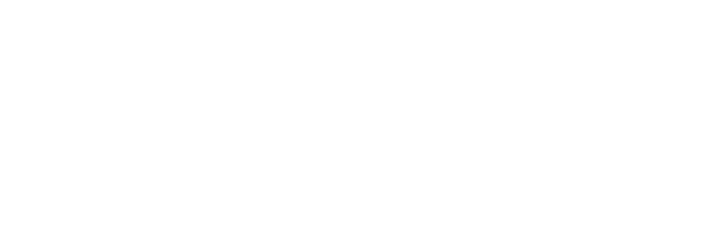

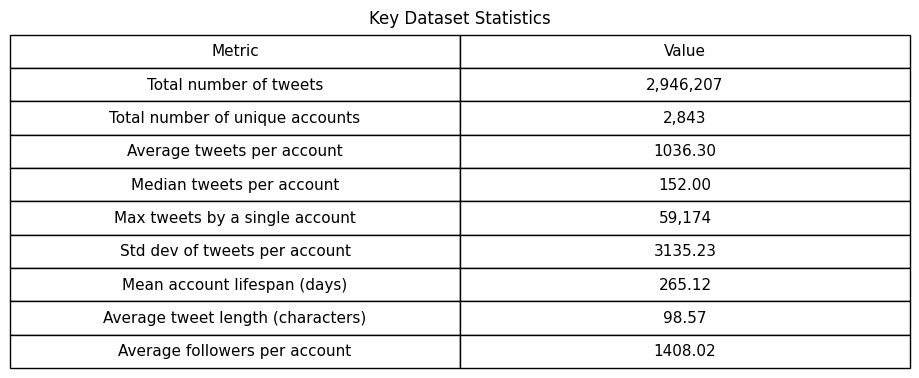

In [4]:
# timestamp column
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df_time = df.withColumn(
    "publish_ts",
    to_timestamp("publish_date", "M/d/yyyy H:mm")
)

# global accounts
total_tweets = df.count()
n_accounts = df.selectExpr("count(distinct author) as n").first()["n"]

# / account stats
acct_stats_spark = (
    df_time.groupBy("author")
           .agg(
               count("*").alias("n_tweets"),
               spark_min("publish_ts").alias("first_ts"),
               spark_max("publish_ts").alias("last_ts"),
               avg("followers").alias("avg_followers")
           )
)

acct_stats = acct_stats_spark.toPandas()

# lifespan
acct_stats["lifespan_days"] = (
    (acct_stats["last_ts"] - acct_stats["first_ts"])
    .dt.total_seconds() / 86400.0
).clip(lower=0)

# acc level metrics
avg_tweets = acct_stats["n_tweets"].mean()
median_tweets = acct_stats["n_tweets"].median()
max_tweets = acct_stats["n_tweets"].max()
std_tweets = acct_stats["n_tweets"].std()

mean_lifespan = acct_stats["lifespan_days"].mean()
avg_followers_per_account = acct_stats["avg_followers"].mean()

# avg tweet length 
avg_tweet_length = (
    df.select(avg(length("content")).alias("avg_len"))
      .first()["avg_len"]
)

# defining stats table 
stats_df = pd.DataFrame({
    "Metric": [
        "Total number of tweets",
        "Total number of unique accounts",
        "Average tweets per account",
        "Median tweets per account",
        "Max tweets by a single account",
        "Std dev of tweets per account",
        "Mean account lifespan (days)",
        "Average tweet length (characters)",
        "Average followers per account",
    ],
    "Value": [
        f"{total_tweets:,}",
        f"{n_accounts:,}",
        f"{avg_tweets:.2f}",
        f"{median_tweets:.2f}",
        f"{max_tweets:,}",
        f"{std_tweets:.2f}",
        f"{mean_lifespan:.2f}",
        f"{avg_tweet_length:.2f}",
        f"{avg_followers_per_account:.2f}",
    ]
})

plt.close('all')

# plt 
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis("off")

# add title above table
fig, ax = plt.subplots(figsize=(9, 3))

# move table lower
ax.set_position([0, -0.05, 1, 1])
ax.axis("off")

plt.title("Key Dataset Statistics", pad=20)

table = ax.table(
    cellText=stats_df.values,
    colLabels=stats_df.columns,
    loc="center",
    cellLoc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

plt.show()

## Temporal Analysis: 

In this part we focus on the **time dimension** of the tweets:

- Convert raw timestamp columns into proper **Spark timestamp / date types**.
- Extract temporal features such as **year, month, day, hour**, and potentially **weekday/weekend**.
- Aggregate tweet counts over time (e.g. per day, month, or year) to visualise **activity trends**.

The plots produced here help us answer questions such as:
- When were these accounts most active?
- Are there visible bursts or campaigns in specific periods?
- How does activity evolve before and after key time points?

These insights are important for later framing of the network and content analyses inside the presentation.


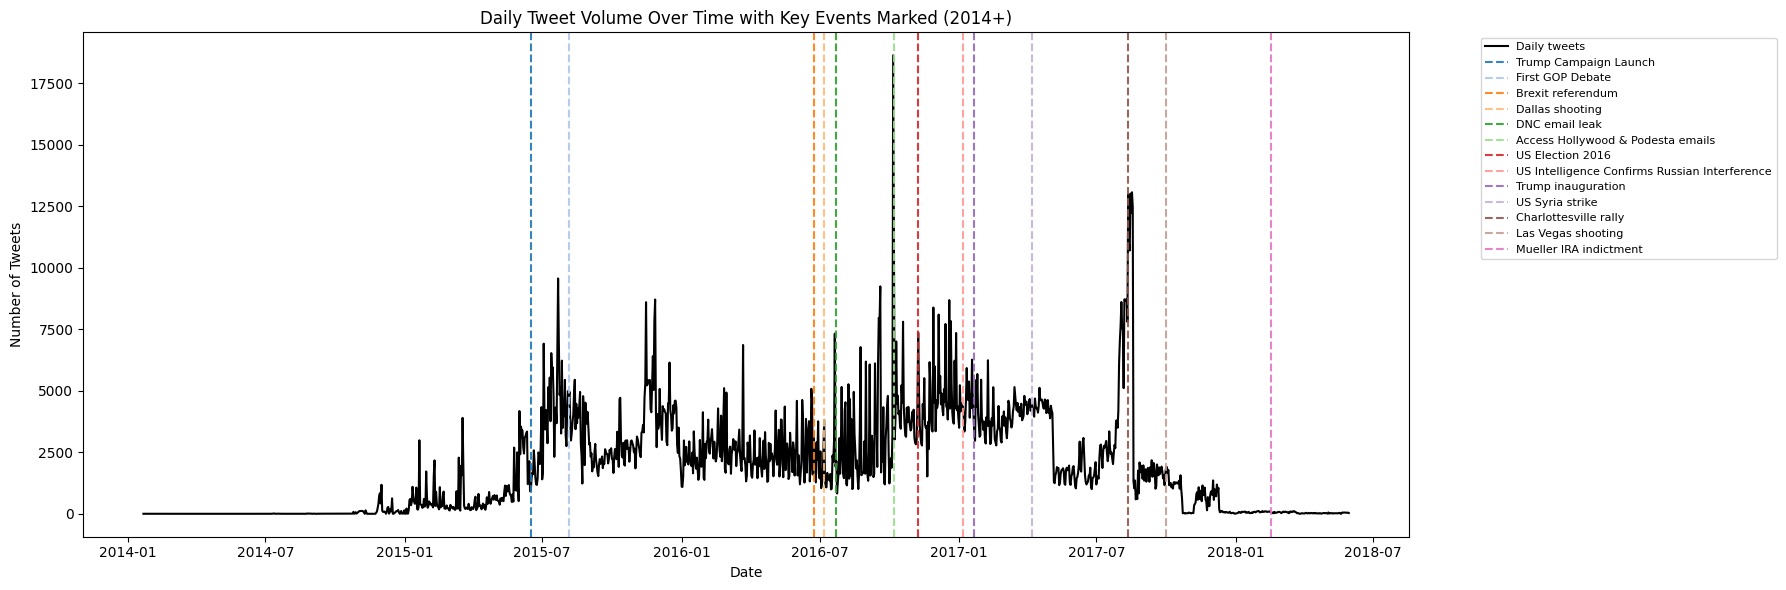

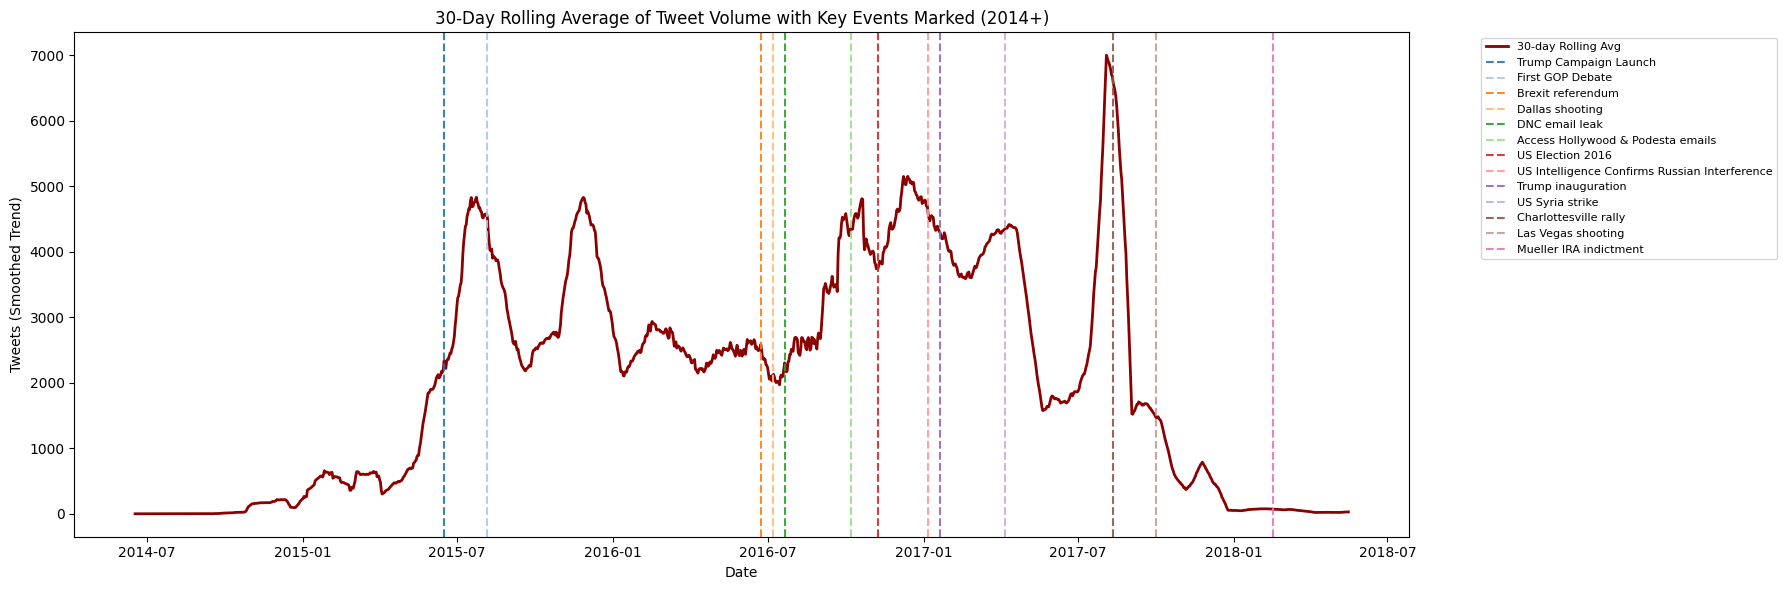

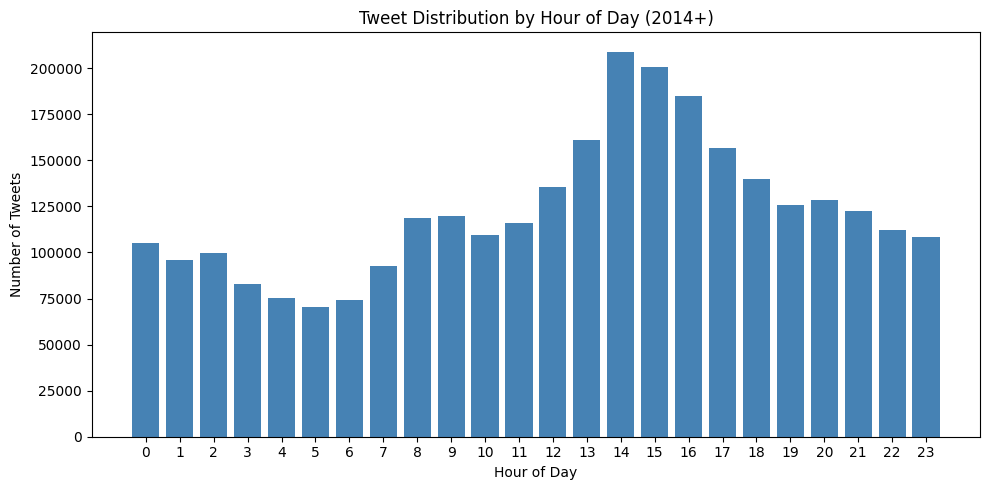

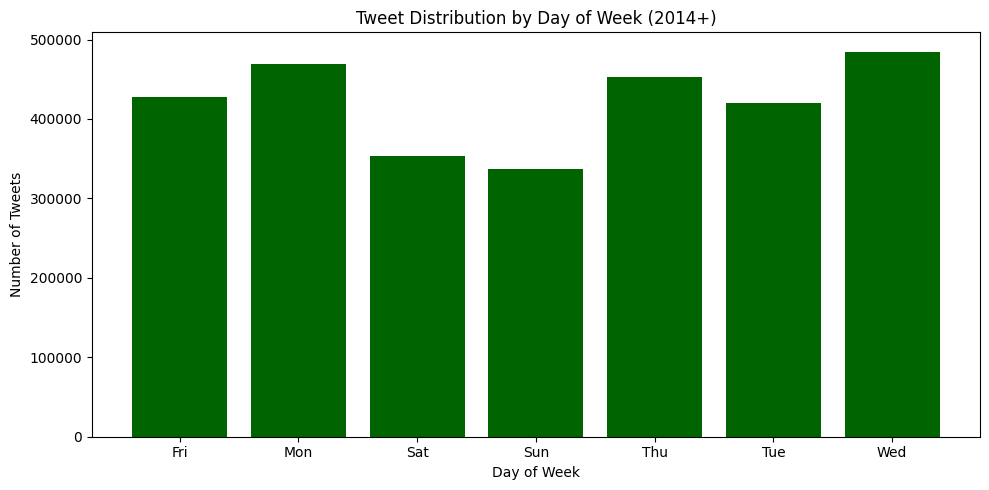

In [5]:
from pyspark.sql.functions import to_timestamp, to_date, hour, date_format
import pandas as pd
import matplotlib.pyplot as plt

# timestamps
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_time = df.withColumn(
    "publish_ts",
    to_timestamp("publish_date", "M/d/yyyy H:mm")
)

# keep only tweets from 2014 onwards
df_time = (
    df_time
        .filter(df_time.publish_ts.isNotNull())
        .filter(df_time.publish_ts >= "2014-01-01")
)

# daily tweet counts
df_daily = (
    df_time
        .withColumn("date", to_date("publish_ts"))
        .groupBy("date")
        .count()
        .orderBy("date")
)

daily_pd = df_daily.toPandas()
daily_pd["date"] = pd.to_datetime(daily_pd["date"])
daily_pd = daily_pd.sort_values("date")

# 30-day rolling avg for second plot
daily_pd["rolling_30"] = daily_pd["count"].rolling(30, center=True).mean()

# load events csv
events_path = "/Users/sanduandrei/Desktop/BigData/data/events/events_temporal_markers.csv"
events_pd = pd.read_csv(events_path)
events_pd["event_date"] = pd.to_datetime(events_pd["date"], format="%m/%d/%Y")

# daily plot for tweet count
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(daily_pd["date"], daily_pd["count"], linewidth=1.5, color="black", label="Daily tweets")

colors = plt.cm.tab20.colors
for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors[idx % len(colors)],
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=row["label"]
    )

ax.set_title("Daily Tweet Volume Over Time with Key Events Marked (2014+)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Tweets")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# 30 day rolling average 
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(daily_pd["date"], daily_pd["rolling_30"], linewidth=2, color="darkred", label="30-day Rolling Avg")

for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors[idx % len(colors)],
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=row["label"]
    )

ax.set_title("30-Day Rolling Average of Tweet Volume with Key Events Marked (2014+)")
ax.set_xlabel("Date")
ax.set_ylabel("Tweets (Smoothed Trend)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# patterns by hour of the day
df_hourly = (
    df_time
        .withColumn("hour", hour("publish_ts"))
        .groupBy("hour")
        .count()
        .orderBy("hour")
)

hourly_pd = df_hourly.toPandas()
plt.figure(figsize=(10,5))
plt.bar(hourly_pd["hour"], hourly_pd["count"], color="steelblue")
plt.title("Tweet Distribution by Hour of Day (2014+)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Tweets")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# patterns by day of the week
df_dow = (
    df_time
        .withColumn("day_of_week", date_format("publish_ts", "E"))
        .groupBy("day_of_week")
        .count()
)

dow_pd = df_dow.toPandas().sort_values("day_of_week")
plt.figure(figsize=(10,5))
plt.bar(dow_pd["day_of_week"], dow_pd["count"], color="darkgreen")
plt.title("Tweet Distribution by Day of Week (2014+)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()


## Campaign Phases: Aggregate Timeline

To move from purely descriptive statistics to a more narrative view, we summarise the
campaign at a **yearly** level along three dimensions:

- **Tweet volume**: total number of tweets per year.
- **Account activations**: number of accounts that become active for the first time in a given year.
- **Account deactivations**: number of accounts whose last tweet falls in a given year.

We aggregate these measures per year, normalise each series to the range \[0, 1\], and plot
them together on a single timeline.

This normalised view highlights **relative changes** and allows us to visually identify
distinct **phases of the campaign**, e.g.:

- a period of onboarding with many activations and low volume,
- a phase of intense activity with peak tweet volume,
- and later years where deactivations become more prominent.

These phases will form the backbone of the narrative in the presentation.


+----+--------+-----------------+--------------------+----------------------+
|year|n_tweets|n_active_accounts|n_activated_accounts|n_deactivated_accounts|
+----+--------+-----------------+--------------------+----------------------+
|2014|    7722|               43|                  43|                     4|
|2015|  822831|             2052|                2013|                  1116|
|2016| 1122885|             1292|                 370|                   612|
|2017|  984501|             1105|                 413|                  1086|
|2018|    7296|               25|                   4|                    25|
+----+--------+-----------------+--------------------+----------------------+



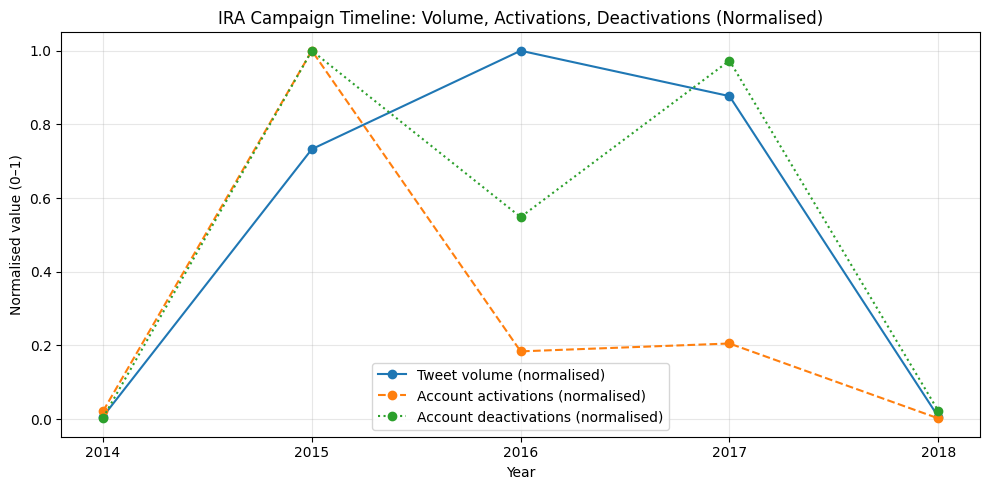

In [6]:
from pyspark.sql import functions as F

# clean time and year columns
df_time_clean = (
    df_time
    .filter(F.col("publish_ts").isNotNull())
    .withColumn("publish_ts", F.col("publish_ts").cast("timestamp"))
    .withColumn("year", F.year("publish_ts"))
)

# after 2014
df_time_clean = df_time_clean.filter(F.col("year") >= 2014)

# tweets per year 
df_yearly_tweets = (
    df_time_clean
    .groupBy("year")
    .agg(
        F.count("*").alias("n_tweets"),
        F.countDistinct("author").alias("n_active_accounts")
    )
)

# first and last year per account
df_author_span = (
    df_time_clean
    .groupBy("author")
    .agg(
        F.min("publish_ts").alias("first_ts"),
        F.max("publish_ts").alias("last_ts")
    )
    .withColumn("first_year", F.year("first_ts"))
    .withColumn("last_year", F.year("last_ts"))
)

# account activation / year 
df_yearly_activation = (
    df_author_span
    .groupBy("first_year")
    .agg(F.count("*").alias("n_activated_accounts"))
    .withColumnRenamed("first_year", "year")
)

# accounts deactivated / year 
df_yearly_deactivation = (
    df_author_span
    .groupBy("last_year")
    .agg(F.count("*").alias("n_deactivated_accounts"))
    .withColumnRenamed("last_year", "year")
)

# one yearly summary table 
df_campaign_timeline = (
    df_yearly_tweets
    .join(df_yearly_activation, on="year", how="left")
    .join(df_yearly_deactivation, on="year", how="left")
    .orderBy("year")
)

df_campaign_timeline.show()

import pandas as pd

campaign_pdf = df_campaign_timeline.toPandas().sort_values("year")

# Fill any missing counts with 0 
campaign_pdf[["n_activated_accounts", "n_deactivated_accounts"]] = (
    campaign_pdf[["n_activated_accounts", "n_deactivated_accounts"]].fillna(0)
)

# Create normalised versions for easier plotting (each series scaled to its own max)
for col in ["n_tweets", "n_activated_accounts", "n_deactivated_accounts"]:
    max_val = campaign_pdf[col].max()
    if max_val > 0:
        campaign_pdf[f"{col}_norm"] = campaign_pdf[col] / max_val
    else:
        campaign_pdf[f"{col}_norm"] = 0.0

campaign_pdf

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    campaign_pdf["year"],
    campaign_pdf["n_tweets_norm"],
    marker="o",
    label="Tweet volume (normalised)"
)
ax.plot(
    campaign_pdf["year"],
    campaign_pdf["n_activated_accounts_norm"],
    marker="o",
    linestyle="--",
    label="Account activations (normalised)"
)
ax.plot(
    campaign_pdf["year"],
    campaign_pdf["n_deactivated_accounts_norm"],
    marker="o",
    linestyle=":",
    label="Account deactivations (normalised)"
)

ax.set_title("IRA Campaign Timeline: Volume, Activations, Deactivations (Normalised)")
ax.set_xlabel("Year")
ax.set_ylabel("Normalised value (0–1)")
ax.set_xticks(campaign_pdf["year"])
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


## Activation and Deactivation Cascades

Here we look at **when accounts appear and disappear** in the data:

- For each handle, compute the **first** and **last** time it tweeted.
- Count how many accounts become active in each time period (e.g. per month or per year).
- Similarly, count how many accounts stop tweeting (“deactivate”) in each period.

Conceptually, this gives us **activation / deactivation cascades** over time:
- Surges in new accounts can signal coordinated onboarding of new personas.
- Clusters of deactivation may correspond to clean-up, bans, or strategic shifts.

These patterns help us understand how the IRA “portfolio” of accounts was managed over time, beyond just raw tweet volume.


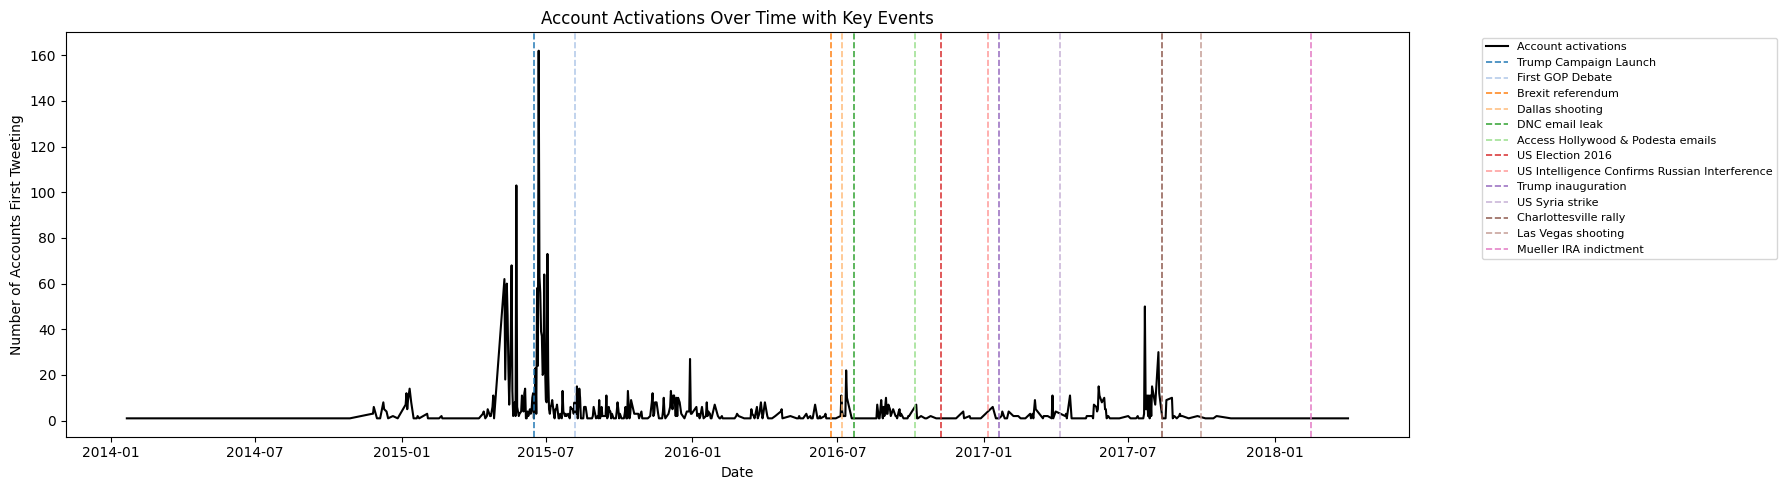

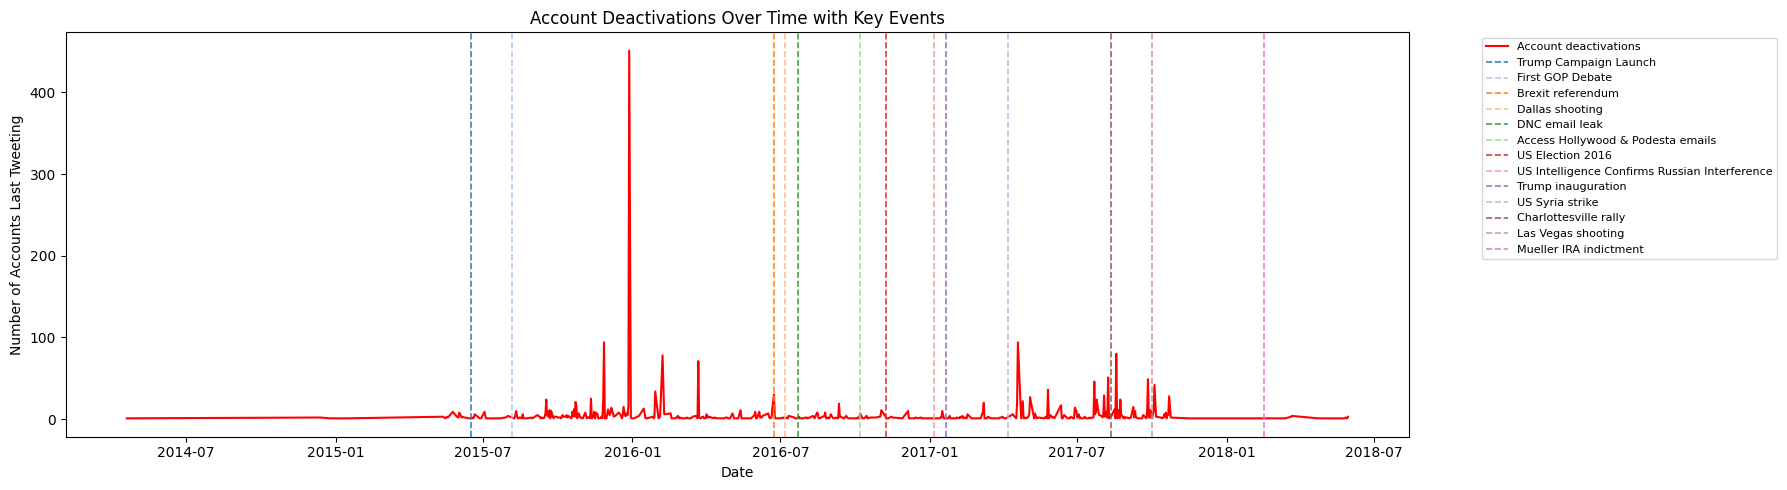

In [7]:
from pyspark.sql.functions import (
    to_timestamp, to_date,
    min as spark_min, max as spark_max
)
import pandas as pd
import matplotlib.pyplot as plt

# timestamp column check 
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

if "df_time" not in globals():
    df_time = df.withColumn(
        "publish_ts",
        to_timestamp("publish_date", "M/d/yyyy H:mm")
    )

df_time = df_time.filter(df_time.publish_ts.isNotNull())
df_time = df_time.filter(df_time.publish_ts >= "2014-01-01")   # <-- ADDED LINE

# 1st and last tweet / account
account_life = (
    df_time.groupBy("author")
           .agg(
               spark_min("publish_ts").alias("first_tweet"),
               spark_max("publish_ts").alias("last_tweet")
           )
)

# activation and deactivation counts / day
activation_df = (
    account_life
        .withColumn("activation_date", to_date("first_tweet"))
        .groupBy("activation_date")
        .count()
        .orderBy("activation_date")
)

deactivation_df = (
    account_life
        .withColumn("deactivation_date", to_date("last_tweet"))
        .groupBy("deactivation_date")
        .count()
        .orderBy("deactivation_date")
)

activation_pd = activation_df.toPandas()
activation_pd["activation_date"] = pd.to_datetime(activation_pd["activation_date"])
activation_pd = activation_pd.sort_values("activation_date")

deactivation_pd = deactivation_df.toPandas()
deactivation_pd["deactivation_date"] = pd.to_datetime(deactivation_pd["deactivation_date"])
deactivation_pd = deactivation_pd.sort_values("deactivation_date")

# load events csv
events_path = "/Users/sanduandrei/Desktop/BigData/data/events/events_temporal_markers.csv"
events_pd = pd.read_csv(events_path)
events_pd["event_date"] = pd.to_datetime(events_pd["date"], format="%m/%d/%Y")

colors = plt.cm.tab20.colors  # color cycle for events

# activation cascades plt 
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(
    activation_pd["activation_date"],
    activation_pd["count"],
    linewidth=1.5,
    color="black",
    label="Account activations"
)

for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors[idx % len(colors)],
        linestyle="--",
        linewidth=1.2,
        alpha=0.9,
        label=row["label"]
    )

ax.set_title("Account Activations Over Time with Key Events")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Accounts First Tweeting")

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# deactivation cascades plt 
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(
    deactivation_pd["deactivation_date"],
    deactivation_pd["count"],
    linewidth=1.5,
    color="red",
    label="Account deactivations"
)

for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors[idx % len(colors)],
        linestyle="--",
        linewidth=1.2,
        alpha=0.9,
        label=row["label"]
    )

ax.set_title("Account Deactivations Over Time with Key Events")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Accounts Last Tweeting")

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


## Investigating activity of accounts belonging to different categories

The IRA accounts are annotated with an **`account_category`** (e.g. LeftTroll, RightTroll, NewsFeed, etc.).  
In this section we:

- Group tweets by `account_category` and time (e.g. monthly counts).
- Compare **activity patterns** across categories: which categories dominate at different points in time?
- Visualise how the relative share of total tweets per category evolves.

The objective is to reveal whether certain categories were:
- Persistent over the whole period,
- Or instead used in **waves** (e.g. bursts of “news feed” accounts followed by more polarised political trolls).

These results are directly useful for slides that contrast **strategic roles** of different account types.


+----+-----+----------------+-----+
|year|month|account_category|count|
+----+-----+----------------+-----+
|2015|7    |RightTroll      |24795|
|2016|7    |RightTroll      |6001 |
|2016|8    |RightTroll      |6261 |
|2016|9    |RightTroll      |39053|
|2015|9    |RightTroll      |4479 |
|2015|11   |RightTroll      |9828 |
|2017|1    |HashtagGamer    |15663|
|2016|11   |HashtagGamer    |20231|
|2014|12   |HashtagGamer    |3137 |
|2016|2    |HashtagGamer    |4153 |
+----+-----+----------------+-----+
only showing top 10 rows



+----------------+------------+
|account_category|total_tweets|
+----------------+------------+
|NonEnglish      |820722      |
|RightTroll      |711625      |
|NewsFeed        |598155      |
|LeftTroll       |427056      |
|HashtagGamer    |241786      |
|Commercial      |121904      |
|Unknown         |13534       |
|Fearmonger      |11140       |
+----------------+------------+



Top categories to plot: ['NonEnglish', 'RightTroll', 'NewsFeed', 'LeftTroll', 'HashtagGamer']


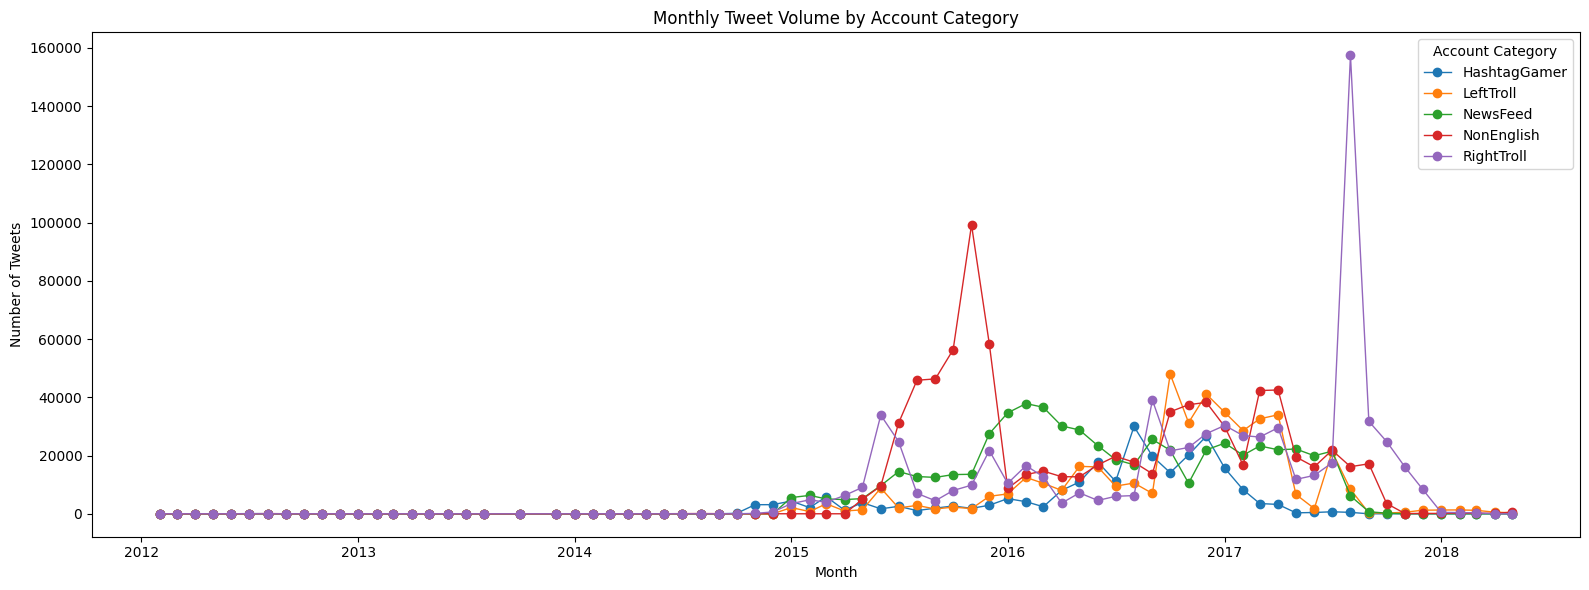

In [8]:
from pyspark.sql import functions as F  # add this if not already run in the session

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_time = df.withColumn(
    "publish_ts",
    F.to_timestamp("publish_date", "M/d/yyyy H:mm")  # handles 1/2/2017 14:39 etc.
)

# tweets per month by account category 
df_cat_monthly = (
    df_time
        .where(F.col("publish_ts").isNotNull())
        .groupBy(
            F.year("publish_ts").alias("year"),
            F.month("publish_ts").alias("month"),
            F.col("account_category")
        )
        .count()
)

df_cat_monthly.show(10, truncate=False)

# top n categories by tweet volume 
cat_totals = (
    df_cat_monthly
        .groupBy("account_category")
        .agg(F.sum("count").alias("total_tweets"))
        .orderBy(F.col("total_tweets").desc())
)

cat_totals.show(truncate=False)

# choose top 4–5 categories for a clean plot
TOP_N = 5
top_categories = [
    row["account_category"]
    for row in cat_totals.limit(TOP_N).collect()
    if row["account_category"] is not None
]

print("Top categories to plot:", top_categories)

# monthly data convert to pandas 
cat_monthly_pd = df_cat_monthly.toPandas()

# filter to top categories only
cat_monthly_pd = cat_monthly_pd[cat_monthly_pd["account_category"].isin(top_categories)]

# build a proper year_month datetime for x-axis
cat_monthly_pd["year_month"] = pd.to_datetime(
    cat_monthly_pd["year"].astype(str) + "-" +
    cat_monthly_pd["month"].astype(str).str.zfill(2) + "-01"
)

# pivot: rows = year_month, columns = account_category, values = tweet counts
pivot = cat_monthly_pd.pivot_table(
    index="year_month",
    columns="account_category",
    values="count",
    aggfunc="sum",
    fill_value=0
).sort_index()

pivot.head()

# Tweets over time by account_category

plt.figure(figsize=(16, 6))

for category in pivot.columns:
    plt.plot(pivot.index, pivot[category], marker="o", linewidth=1, label=category)

plt.title("Monthly Tweet Volume by Account Category")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.legend(title="Account Category")
plt.tight_layout()
plt.show()


## Tweet distribution statistics
- Detecting spread of nunique tweets

We now move from aggregate time series to **per-account behaviour**:

- Compute the **distribution of tweet counts per account**.
- Summarise this distribution with descriptive statistics (mean, median, percentiles).
- Visualise it (often on a log scale) to see how skewed the activity is.

This tells us whether most accounts tweet a similar amount, or whether there are:
- Many low-activity accounts, and
- A small number of very prolific accounts.

Understanding this distribution is key before performing any **outlier detection** or focusing on “heavy hitters”.


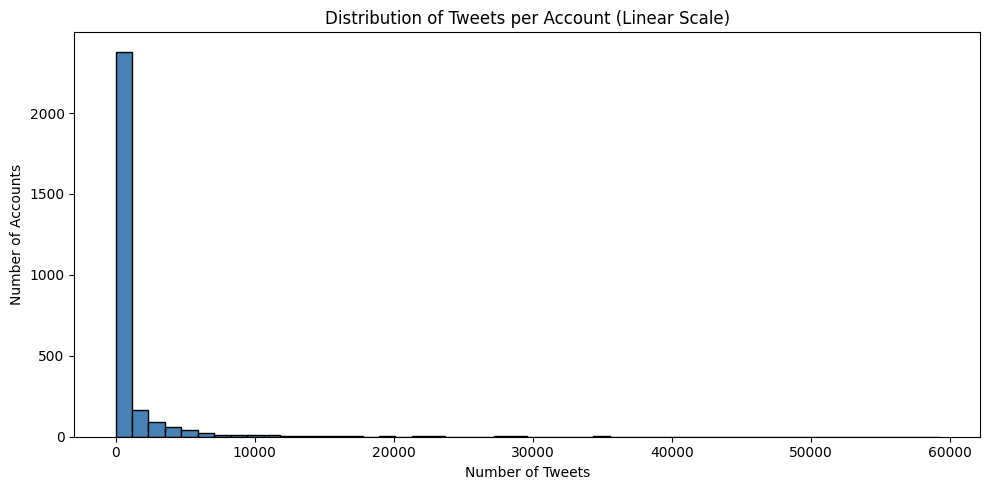

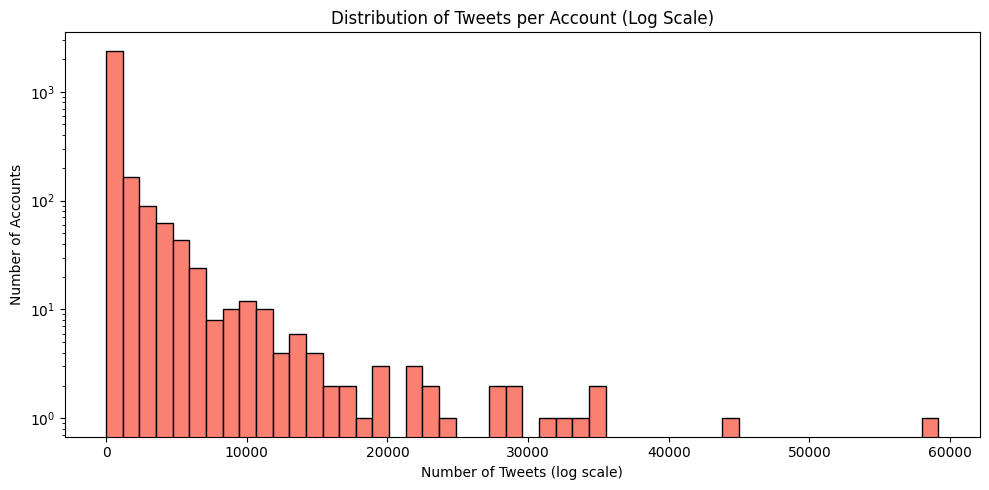

In [9]:
tweets_per_account_spark = (
    df.groupBy("author")
      .count()
      .withColumnRenamed("count", "tweets_per_account")
)

tweets_per_account = tweets_per_account_spark.toPandas()

plt.figure(figsize=(10, 5))
plt.hist(tweets_per_account["tweets_per_account"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Tweets per Account (Linear Scale)")
plt.xlabel("Number of Tweets")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(tweets_per_account["tweets_per_account"], bins=50, color="salmon", edgecolor="black", log=True)
plt.title("Distribution of Tweets per Account (Log Scale)")
plt.xlabel("Number of Tweets (log scale)")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

## Detecting outliers 

Based on the tweet count distribution, we next identify **outlier accounts**:

- Define a rule to flag unusually active accounts (e.g. top percentile, IQR-based threshold, or a fixed cut-off).
- Extract a list of accounts whose tweet volume is far above the bulk of the distribution.
- Optionally visualise the threshold on top of the histogram / density plot.

These outliers are candidates for:
- **Central operational accounts** or hubs in the campaign,
- Or automated / scripted behaviour.

Later, we will relate these particularly active accounts to both **textual themes** and **network position**.


In [10]:
from pyspark.sql.functions import col
from pyspark.sql.functions import count as spark_count

# tweets per account
tweets_per_account = (
    df.groupBy("author")
      .agg(spark_count("*").alias("tweets_per_account"))
)

# high activity datasets
accounts_over_50000 = tweets_per_account.filter(col("tweets_per_account") > 50000)
accounts_over_40000 = tweets_per_account.filter(col("tweets_per_account") > 40000)

print("\nAccounts with > 50,000 tweets:")
accounts_over_50000.show(truncate=False)

print("\nAccounts with > 40,000 tweets:")
accounts_over_40000.show(truncate=False)

# convert to pandas for percentile calc
tp_pd = tweets_per_account.toPandas()

# 95th percentile
p95_threshold = tp_pd["tweets_per_account"].quantile(0.95)
print(f"\n95th percentile tweet count threshold: {p95_threshold:.2f}")

# number of unique accounts above 95th percentile
n_above_95 = (tp_pd["tweets_per_account"] > p95_threshold).sum()
print(f"Number of accounts above 95th percentile: {n_above_95}")

# show accounts above 95th percentile
accounts_above_95 = tweets_per_account.filter(col("tweets_per_account") > p95_threshold)
accounts_above_95.show(truncate=False)



Accounts with > 50,000 tweets:


+-------+------------------+
|author |tweets_per_account|
+-------+------------------+
|EXQUOTE|59174             |
+-------+------------------+


Accounts with > 40,000 tweets:


+-------------+------------------+
|author       |tweets_per_account|
+-------------+------------------+
|EXQUOTE      |59174             |
|SCREAMYMONKEY|44001             |
+-------------+------------------+




95th percentile tweet count threshold: 4845.60
Number of accounts above 95th percentile: 143


+---------------+------------------+
|author         |tweets_per_account|
+---------------+------------------+
|COOKNCOOKS     |5017              |
|DAILYLOSANGELES|14122             |
|DAILYSANFRAN   |27996             |
|CHRIXMORGAN    |14705             |
|COMRADZAMPOLIT |9581              |
|CASSISHERE     |5661              |
|CHADSLOYER     |5259              |
|CHESPLAYSCHESS |19216             |
|COVFEFENATIONUS|23544             |
|CRYSTAL1JOHNSON|8067              |
|CHAASNTR       |8287              |
|CHICAGODAILYNEW|22148             |
|CURTISBIGMAN   |5021              |
|DAILYSANDIEGO  |14381             |
|BATONROUGEVOICE|10740             |
|BIZGOD         |12156             |
|BOEING_IS_BACK |4932              |
|BOOTH_PRINCE   |9551              |
|BRENTMCCLURE275|7286              |
|BRIANAREGLAND  |6578              |
+---------------+------------------+
only showing top 20 rows



## Further exploration of the outliers 

After identifying high-activity accounts, we examine their characteristics in more detail:

- Break down outlier accounts by **account_category** to see which categories dominate among heavy hitters.
- Inspect basic temporal patterns (e.g. are these accounts active for longer periods? do they have sustained high activity?).
- Optionally look at exemplar tweets to qualitatively understand what these accounts are doing.

This helps answer questions such as:
- Are the most active accounts primarily “news feeds”, “political trolls”, or something else?
- Do these accounts behave differently over time compared to the typical account?

These insights will feed nicely into slides that highlight a **small core of highly active operators**.


In [11]:
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

tp_pd = tweets_per_account.toPandas()
p95_threshold = tp_pd["tweets_per_account"].quantile(0.95)

p95_threshold

accounts_above_95 = (
    tweets_per_account
        .filter(col("tweets_per_account") > p95_threshold)
        .withColumnRenamed("author", "account")
)

accounts_above_95.show(truncate=False)
print("Number of accounts above 95th percentile:", accounts_above_95.count())

df_top5 = (
    df.join(accounts_above_95, df.author == accounts_above_95.account, "inner")
      .drop(accounts_above_95.account)
)

df_top5.printSchema()
print("Total tweets from top 5% accounts:", df_top5.count())


+---------------+------------------+
|account        |tweets_per_account|
+---------------+------------------+
|COOKNCOOKS     |5017              |
|DAILYLOSANGELES|14122             |
|DAILYSANFRAN   |27996             |
|CHRIXMORGAN    |14705             |
|COMRADZAMPOLIT |9581              |
|CASSISHERE     |5661              |
|CHADSLOYER     |5259              |
|CHESPLAYSCHESS |19216             |
|COVFEFENATIONUS|23544             |
|CRYSTAL1JOHNSON|8067              |
|CHAASNTR       |8287              |
|CHICAGODAILYNEW|22148             |
|CURTISBIGMAN   |5021              |
|DAILYSANDIEGO  |14381             |
|BATONROUGEVOICE|10740             |
|BIZGOD         |12156             |
|BOEING_IS_BACK |4932              |
|BOOTH_PRINCE   |9551              |
|BRENTMCCLURE275|7286              |
|BRIANAREGLAND  |6578              |
+---------------+------------------+
only showing top 20 rows



Number of accounts above 95th percentile: 143
root
 |-- external_author_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- content: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- harvested_date: string (nullable = true)
 |-- following: integer (nullable = true)
 |-- followers: integer (nullable = true)
 |-- updates: integer (nullable = true)
 |-- post_type: string (nullable = true)
 |-- account_type: string (nullable = true)
 |-- retweet: integer (nullable = true)
 |-- account_category: string (nullable = true)
 |-- new_june_2018: integer (nullable = true)
 |-- alt_external_id: string (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- article_url: string (nullable = true)
 |-- tco1_step1: string (nullable = true)
 |-- tco2_step1: string (nullable = true)
 |-- tco3_step1: string (nullable = true)
 |-- tweets_per_account: long (nullable = false)



Total tweets from top 5% accounts: 1598931


## Text and Topic Exploration

We now turn to the **content of the tweets** and investigate what these accounts talk about:

- Clean and normalise tweet text (lowercasing, removing URLs / punctuation, tokenisation).
- Filter to **English-language tweets** and a relevant time window (e.g. from 2014 onwards).
- Compute basic word frequencies to obtain a first view on dominant terms.

The goal is not to build a full topic model at this stage, but to:
- Identify **recurring themes and narratives**,
- And set up the foundation for more structured analysis of vocabularies and bigrams.


In [12]:
from pyspark.sql.functions import col, lower, regexp_replace, split, explode, year
from pyspark.ml.feature import StopWordsRemover

# restrict to english words and start from 2014 
df_text = (
    df_time
        .filter(col("language") == "English")
        .filter(df_time.publish_ts >= "2014-01-01")
)

# text cleaning
df_clean = (
    df_text
        .withColumn("text_lower", lower(col("content")))
        .fillna({"text_lower": ""})
        # remove URLs
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"http\S+", " "))
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"www\.\S+", " "))
        # remove @mentions
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"@\w+", " "))
        # keep letters only; remove hashtags entirely
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"#\w+", " "))   # <-- REMOVE HASHTAGS
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"[^a-z]", " "))
        # collapse whitespace
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"\s+", " "))
)

# tokenize
df_tokens = df_clean.withColumn("token", explode(split(col("text_lower"), " ")))

# stopword filter
stopwords = StopWordsRemover.loadDefaultStopWords("english")
extra_stops = ["rt", "amp", "https", "http"]
stopwords_all = stopwords + extra_stops

df_words = (
    df_tokens
        .filter(col("token") != "")
        .filter(~col("token").isin(stopwords_all))
)


from pyspark.sql.functions import desc

top_words_global = (
    df_words.groupBy("token")
            .count()
            .orderBy(desc("count"))
)

top_words_global.show(50, truncate=False)


df_words_year = df_words.withColumn("year", year(col("publish_ts")))
df_words_year = df_words_year.filter(col("year").between(2015, 2017))

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

words_per_year = (
    df_words_year
        .groupBy("year", "token")
        .count()
)

w = Window.partitionBy("year").orderBy(desc("count"))

top_words_per_year = (
    words_per_year
        .withColumn("rn", row_number().over(w))
        .filter(col("rn") <= 20)
        .orderBy("year", "rn")
)

top_words_per_year.show(60, truncate=False)



+---------+------+
|token    |count |
+---------+------+
|trump    |155871|
|new      |70091 |
|police   |57800 |
|man      |55804 |
|people   |54859 |
|obama    |47157 |
|get      |46447 |
|like     |46319 |
|m        |45542 |
|u        |43796 |
|one      |42726 |
|workout  |42232 |
|us       |42009 |
|black    |39141 |
|video    |36923 |
|says     |36088 |
|hillary  |34373 |
|president|32118 |
|white    |31529 |
|time     |31468 |
|day      |31212 |
|breaking |30298 |
|re       |30037 |
|clinton  |29891 |
|via      |28643 |
|state    |28120 |
|year     |28021 |
|make     |27357 |
|need     |26619 |
|know     |26402 |
|good     |26050 |
|america  |25948 |
|go       |25604 |
|woman    |25306 |
|want     |24698 |
|first    |24516 |
|back     |24477 |
|say      |23620 |
|love     |23187 |
|news     |23123 |
|right    |22584 |
|killed   |22479 |
|house    |22192 |
|today    |21729 |
|media    |21579 |
|see      |21311 |
|never    |20844 |
|look     |20238 |
|old      |20058 |
|life     |2

+----+---------+-----+---+
|year|token    |count|rn |
+----+---------+-----+---+
|2015|workout  |41903|1  |
|2015|exercise |13810|2  |
|2015|new      |12978|3  |
|2015|police   |12225|4  |
|2015|u        |11806|5  |
|2015|obama    |11600|6  |
|2015|m        |11522|7  |
|2015|man      |11110|8  |
|2015|like     |10000|9  |
|2015|weight   |9513 |10 |
|2015|get      |8872 |11 |
|2015|people   |8833 |12 |
|2015|says     |8816 |13 |
|2015|need     |8345 |14 |
|2015|good     |8129 |15 |
|2015|one      |7836 |16 |
|2015|lose     |7649 |17 |
|2015|us       |6843 |18 |
|2015|time     |6842 |19 |
|2015|day      |6519 |20 |
|2016|trump    |49391|1  |
|2016|new      |28641|2  |
|2016|police   |26002|3  |
|2016|people   |25740|4  |
|2016|man      |24131|5  |
|2016|m        |21250|6  |
|2016|black    |21222|7  |
|2016|like     |19836|8  |
|2016|hillary  |19597|9  |
|2016|get      |19472|10 |
|2016|clinton  |19039|11 |
|2016|u        |18775|12 |
|2016|one      |17654|13 |
|2016|us       |17516|14 |
|

25/12/09 17:30:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


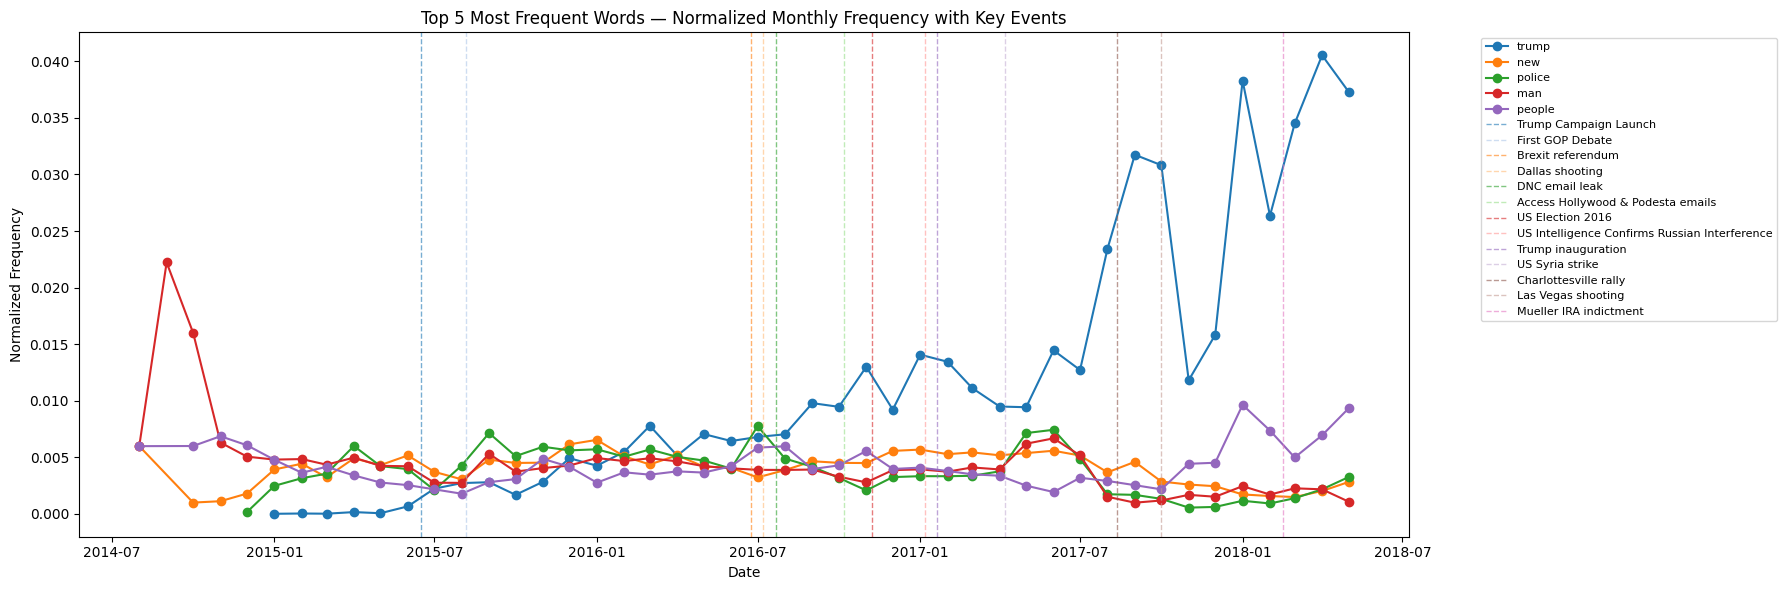

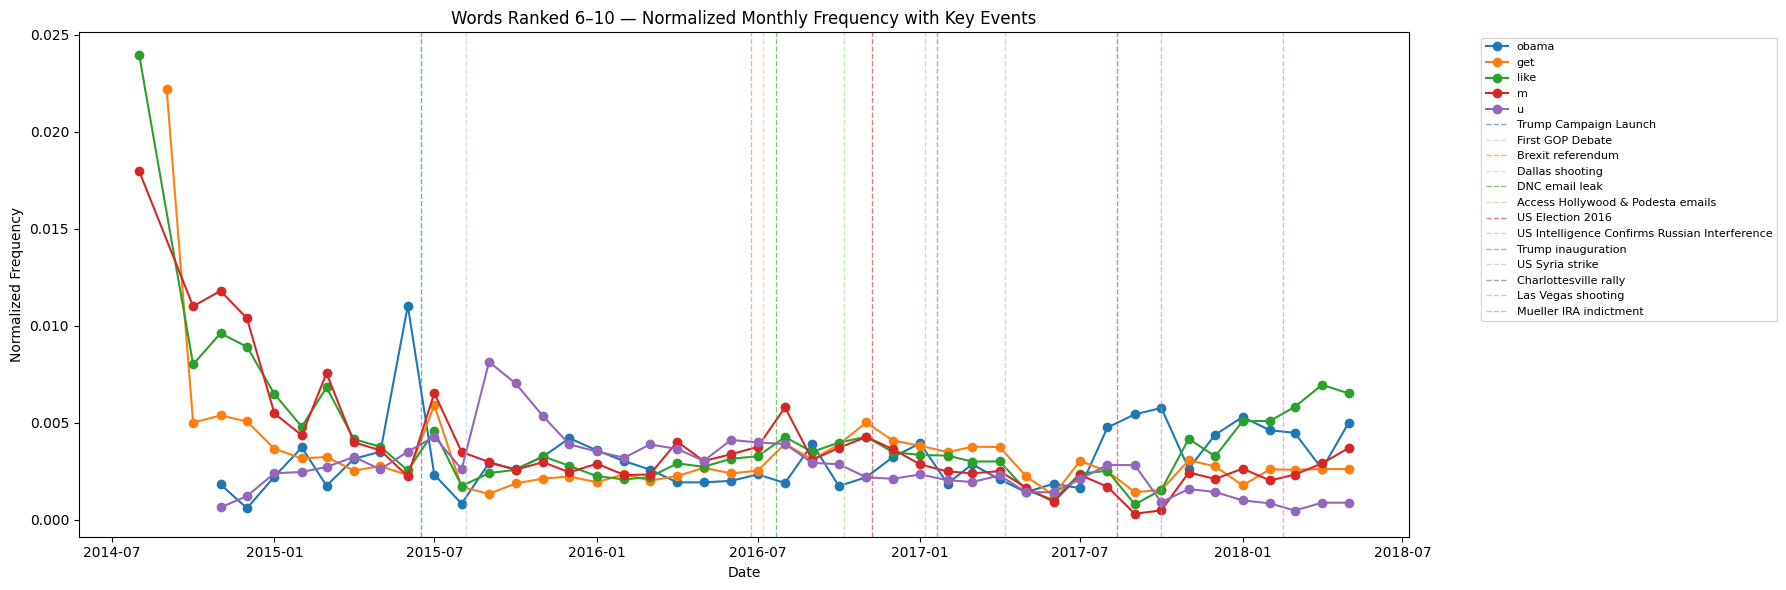

In [13]:
from pyspark.sql.functions import desc, year, month, col
import pandas as pd
import matplotlib.pyplot as plt

# top 20 words but we only use top 10 later 
top20 = (
    df_words.groupBy("token")
            .count()
            .orderBy(desc("count"))
            .limit(20)
            .toPandas()
)

top20 = top20.sort_values("count", ascending=False).reset_index(drop=True)

top10_words = top20["token"].iloc[:5].tolist()      # top 5
next10_words = top20["token"].iloc[5:10].tolist()   # ranks 6–10

top10_words, next10_words

# monthly counts per word
df_words_monthly = (
    df_words
        .withColumn("year", year(col("publish_ts")))
        .withColumn("month", month(col("publish_ts")))
        .groupBy("year", "month", "token")
        .count()
)

words_monthly_pd = df_words_monthly.toPandas()
words_monthly_pd["year_month"] = pd.to_datetime(
    words_monthly_pd["year"].astype(str) + "-" +
    words_monthly_pd["month"].astype(str).str.zfill(2) + "-01"
)
words_monthly_pd = words_monthly_pd.sort_values("year_month")

# monthly total word counts
df_monthly_totals = (
    df_words
        .withColumn("year", year(col("publish_ts")))
        .withColumn("month", month(col("publish_ts")))
        .groupBy("year", "month")
        .count()
        .withColumnRenamed("count", "total_words_month")
)

monthly_totals_pd = df_monthly_totals.toPandas()
monthly_totals_pd["year_month"] = pd.to_datetime(
    monthly_totals_pd["year"].astype(str) + "-" +
    monthly_totals_pd["month"].astype(str).str.zfill(2) + "-01"
)

# compute normalized frequency 
wm = words_monthly_pd.merge(
    monthly_totals_pd[["year_month", "total_words_month"]],
    on="year_month",
    how="left"
)

wm["norm_freq"] = wm["count"] / wm["total_words_month"]

# load events csv 
events_path = "/Users/sanduandrei/Desktop/BigData/data/events/events_temporal_markers.csv"
events_pd = pd.read_csv(events_path)
events_pd["event_date"] = pd.to_datetime(events_pd["date"], format="%m/%d/%Y")

colors_events = plt.cm.tab20.colors

# plt top 5 words normalized
fig, ax = plt.subplots(figsize=(18, 6))

df_top10 = wm[wm["token"].isin(top10_words)]

for word in top10_words:
    sub = df_top10[df_top10["token"] == word]
    ax.plot(sub["year_month"], sub["norm_freq"], marker="o", linewidth=1.5, label=word)

for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors_events[idx % len(colors_events)],
        linestyle="--",
        linewidth=1,
        alpha=0.6,
        label=row["label"]
    )

ax.set_title("Top 5 Most Frequent Words — Normalized Monthly Frequency with Key Events")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Frequency")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# plt words 6-10 normalized
fig, ax = plt.subplots(figsize=(18, 6))

df_next10 = wm[wm["token"].isin(next10_words)]

for word in next10_words:
    sub = df_next10[df_next10["token"] == word]
    ax.plot(sub["year_month"], sub["norm_freq"], marker="o", linewidth=1.5, label=word)

for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors_events[idx % len(colors_events)],
        linestyle="--",
        linewidth=1,
        alpha=0.6,
        label=row["label"]
    )

ax.set_title("Words Ranked 6–10 — Normalized Monthly Frequency with Key Events")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Frequency")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


### Category-Specific Vocabularies

Using the cleaned tokens, we compare vocabularies across **account categories**:

- For each `account_category`, compute the **most frequent words**.
- Optionally filter out stopwords and very generic terms to focus on informative tokens.
- Present the top words per category in tables or bar charts.

This allows us to see how different categories specialise in different narratives, for example:
- “News feed” style accounts focusing on neutral news or event descriptors.
- Political troll accounts using more **ideologically charged** or **polarising** vocabulary.

These contrasts are useful to show in the presentation to illustrate how **messaging was tailored** by role.


+----------------+--------+
|account_category|n_tokens|
+----------------+--------+
|RightTroll      |5505541 |
|NewsFeed        |4399983 |
|LeftTroll       |3156325 |
|HashtagGamer    |1177173 |
|Commercial      |561388  |
|NonEnglish      |186235  |
|Fearmonger      |57758   |
|Unknown         |40554   |
+----------------+--------+



Top categories: ['RightTroll', 'NewsFeed', 'LeftTroll', 'HashtagGamer', 'Commercial']


+----------------+---------+------+----+
|account_category|token    |count |rank|
+----------------+---------+------+----+
|Commercial      |workout  |41840 |1   |
|Commercial      |exercise |13664 |2   |
|Commercial      |weight   |9269  |3   |
|Commercial      |lose     |6804  |4   |
|Commercial      |need     |4528  |5   |
|Commercial      |good     |4481  |6   |
|Commercial      |m        |4174  |7   |
|Commercial      |get      |3548  |8   |
|Commercial      |stocks   |3334  |9   |
|Commercial      |go       |3162  |10  |
|Commercial      |today    |3127  |11  |
|Commercial      |fitness  |2977  |12  |
|Commercial      |diet     |2783  |13  |
|Commercial      |loans    |2418  |14  |
|Commercial      |loss     |2276  |15  |
|Commercial      |like     |2269  |16  |
|Commercial      |time     |2262  |17  |
|Commercial      |payday   |2158  |18  |
|Commercial      |fat      |2156  |19  |
|Commercial      |day      |1972  |20  |
|HashtagGamer    |m        |10735 |1   |
|HashtagGamer   

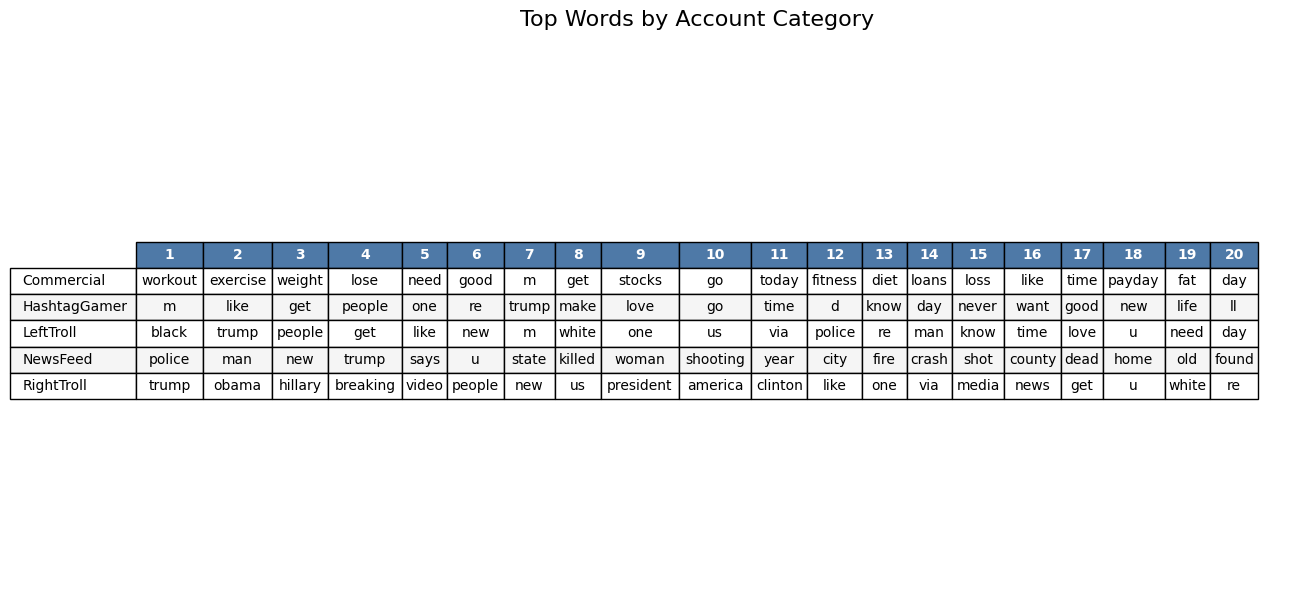

In [14]:
from pyspark.sql.functions import col, desc, count as spark_count, row_number
from pyspark.sql.window import Window

# category and sizes 
category_counts = (
    df_words
        .groupBy("account_category")
        .agg(spark_count("*").alias("n_tokens"))
        .orderBy(desc("n_tokens"))
)

category_counts.show(truncate=False)

# only top n categories, keeps things readable 
TOP_CATS = 5
top_categories = [
    row["account_category"]
    for row in category_counts.limit(TOP_CATS).collect()
    if row["account_category"] is not None
]

print("Top categories:", top_categories)

df_words_cat = df_words.filter(col("account_category").isin(top_categories))

# word frequencies per category 
words_by_cat = (
    df_words_cat
        .groupBy("account_category", "token")
        .agg(spark_count("*").alias("count"))
)

# rank words by frequency 
TOP_K = 20

w_cat = Window.partitionBy("account_category").orderBy(desc("count"))

top_words_by_cat = (
    words_by_cat
        .withColumn("rank", row_number().over(w_cat))
        .filter(col("rank") <= TOP_K)
        .orderBy("account_category", "rank")
)

top_words_by_cat.show(200, truncate=False)

import pandas as pd
import matplotlib.pyplot as plt

# convert to pandas
top_words_pd = top_words_by_cat.toPandas()

# pivot so each category is a row, each rank a column
table_df = (
    top_words_pd
        .sort_values(["account_category", "rank"])
        .pivot(index="account_category", columns="rank", values="token")
)

# column headers: 1, 2, 3, ...
table_df.columns = [str(i) for i in table_df.columns]

# matplotlib table 
fig, ax = plt.subplots(figsize=(14, 4 + 0.4 * len(table_df)))
ax.axis("off")

mpl_table = ax.table(
    cellText=table_df.values,
    rowLabels=table_df.index,
    colLabels=table_df.columns,
    cellLoc="center",
    loc="center"
)

mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(10)
mpl_table.scale(1.3, 1.4)

# make columns a bit wider so words fit better
mpl_table.auto_set_column_width(col=list(range(len(table_df.columns) + 1)))

# style header row
for (row, col), cell in mpl_table.get_celld().items():
    if row == 0:  # header row
        cell.set_text_props(weight="bold", color="white")
        cell.set_facecolor("#4E79A7")

# zebra-strip data rows
for (row, col), cell in mpl_table.get_celld().items():
    if row > 0:  # skip header
        if row % 2 == 0:
            cell.set_facecolor("#F5F5F5")
        else:
            cell.set_facecolor("white")

plt.title("Top Words by Account Category", fontsize=16, pad=25)
plt.tight_layout()
plt.show()



## Bigram Analysis (Two-Word Topics)

Single words can be ambiguous, so we next look at **bigrams** (two-word sequences) as proxies for simple “topics”:

- Construct bigrams from the cleaned token sequences.
- Count bigram frequencies over the corpus.
- Filter to informative bigrams (e.g. minimum frequency) to remove noise.

Common bigrams such as “breaking news”, “gun control”, or “police shooting” (exact examples depend on results) typically correspond to more concrete issues or frames.

This analysis provides a more **structured view of narratives** than unigrams alone and is easy to translate into clear slide visuals.


Top 30 bigrams overall:


25/12/09 17:30:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:30:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:30:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:30:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:30:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:30:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:30:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:30:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:30:55 WARN RowBasedKeyValueBatch: Calling spill() on

+----------------+-----+
|bigram          |count|
+----------------+-----+
|donald trump    |15019|
|year old        |11902|
|hillary clinton |9314 |
|white house     |8953 |
|president trump |8011 |
|lose weight     |6756 |
|north korea     |6714 |
|new york        |6160 |
|new orleans     |5202 |
|fake news       |4469 |
|islamic state   |4335 |
|anti trump      |4053 |
|high school     |3912 |
|trump supporters|3837 |
|supreme court   |3652 |
|police say      |3337 |
|police officer  |3262 |
|black people    |3122 |
|san francisco   |2892 |
|looks like      |2887 |
|st louis        |2866 |
|bernie sanders  |2810 |
|cnn cnn         |2785 |
|white people    |2784 |
|u n             |2746 |
|bill clinton    |2668 |
|san jose        |2624 |
|lives matter    |2589 |
|fox news        |2565 |
|social media    |2546 |
+----------------+-----+
only showing top 30 rows

Top 15 bigrams per year (2015–2017):


25/12/09 17:31:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:08 WARN RowBasedKeyValueBatch: Calling spill() on

+----+----------------+-----+----+
|year|bigram          |count|rank|
+----+----------------+-----+----+
|2015|lose weight     |6621 |1   |
|2015|weight loss     |2258 |2   |
|2015|bb sp           |2133 |3   |
|2015|year old        |2001 |4   |
|2015|islamic state   |1954 |5   |
|2015|good workout    |1898 |6   |
|2015|donald trump    |1844 |7   |
|2015|new york        |1762 |8   |
|2015|workout today   |1403 |9   |
|2015|pre workout     |1380 |10  |
|2015|go workout      |1359 |11  |
|2015|hillary clinton |1342 |12  |
|2015|cbs news        |1154 |13  |
|2015|white house     |1039 |14  |
|2015|u n             |1000 |15  |
|2016|donald trump    |8324 |1   |
|2016|hillary clinton |5992 |2   |
|2016|year old        |4615 |3   |
|2016|new york        |2448 |4   |
|2016|white house     |2378 |5   |
|2016|new orleans     |2292 |6   |
|2016|payday loans    |2121 |7   |
|2016|islamic state   |2112 |8   |
|2016|black people    |1976 |9   |
|2016|bernie sanders  |1860 |10  |
|2016|san jose      

25/12/09 17:31:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:22 WARN RowBasedKeyValueBatch: Calling spill() on

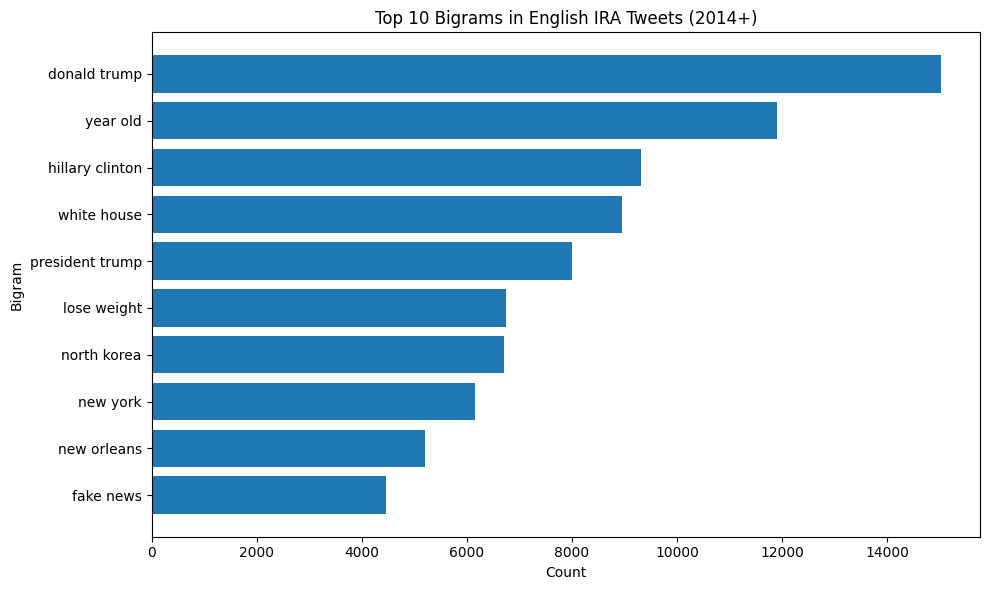

In [15]:
from pyspark.sql.functions import (
    col, lower, regexp_replace, split, explode,
    year, desc
)
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.ml.feature import StopWordsRemover
import pandas as pd
import matplotlib.pyplot as plt


df_text_big = (
    df_time
        .filter(col("language") == "English")
        .filter(df_time.publish_ts >= "2014-01-01")
        .select("publish_ts", "account_category", "content")
)

# Clean text (similar to unigram analysis, but keep arrays)
#    - lowercase
#    - remove URLs, mentions, hashtags, non-letters

df_clean_big = (
    df_text_big
        .withColumn("text_lower", lower(col("content")))
        .fillna({"text_lower": ""})
        # remove URLs
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"http\S+", " "))
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"www\.\S+", " "))
        # remove @mentions
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"@\w+", " "))
        # remove hashtags entirely
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"#\w+", " "))
        # keep letters only
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"[^a-z]", " "))
        # collapse whitespace
        .withColumn("text_lower", regexp_replace(col("text_lower"), r"\s+", " "))
)

# tokenize into raw tokens (arrays)
df_tokens_big = df_clean_big.withColumn("tokens_raw", split(col("text_lower"), " "))

# remove stopwords
stopwords = set(StopWordsRemover.loadDefaultStopWords("english") +
                ["rt", "amp", "https", "http", ""])

@udf(ArrayType(StringType()))
def filter_stopwords(tokens):
    if tokens is None:
        return []
    return [t for t in tokens if t not in stopwords]

df_tokens_big = df_tokens_big.withColumn("tokens_clean", filter_stopwords(col("tokens_raw")))

# build histogram
@udf(ArrayType(StringType()))
def make_bigrams(tokens):
    if tokens is None:
        return []
    return [tokens[i] + " " + tokens[i+1] for i in range(len(tokens) - 1)]

df_bigrams = df_tokens_big.withColumn("bigrams", make_bigrams(col("tokens_clean")))

# explode to one bigram per row
df_bigrams_exploded = (
    df_bigrams
        .select("publish_ts", "account_category", explode(col("bigrams")).alias("bigram"))
        .filter(col("bigram") != "")
)

# top bigrams overall
top_bigrams_overall = (
    df_bigrams_exploded
        .groupBy("bigram")
        .count()
        .orderBy(desc("count"))
)

print("Top 30 bigrams overall:")
top_bigrams_overall.show(30, truncate=False)

# top bigrams by year (2015–2017, for example)
df_big_year = df_bigrams_exploded.withColumn("year", year(col("publish_ts")))
df_big_year = df_big_year.filter(col("year").between(2015, 2017))

bigrams_year_counts = (
    df_big_year
        .groupBy("year", "bigram")
        .count()
)

w = Window.partitionBy("year").orderBy(desc("count"))

top_bigrams_per_year = (
    bigrams_year_counts
        .withColumn("rank", row_number().over(w))
        .filter(col("rank") <= 15)
        .orderBy("year", "rank")
)

print("Top 15 bigrams per year (2015–2017):")
top_bigrams_per_year.show(60, truncate=False)

# bar chart top 10 bigrams
top10_bigrams_pd = top_bigrams_overall.limit(10).toPandas().sort_values("count", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top10_bigrams_pd["bigram"], top10_bigrams_pd["count"])
plt.title("Top 10 Bigrams in English IRA Tweets (2014+)")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()

### Investigating Bigram frequency per year

To connect content with time, we study how bigram usage evolves **year by year**:

- Recompute bigram counts grouped by **year**.
- For selected bigrams (e.g. the top ones overall), track their frequency across years.
- Visualise these trajectories to see when specific narratives are emphasised.

This helps us identify:
- **Issue cycles** (topics that spike around particular years or events),
- And whether new narratives were introduced or old ones were phased out.

These time-resolved plots are particularly useful for the presentation to show **how messaging adapted over time**.


25/12/09 17:31:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:33 WARN RowBasedKeyValueBatch: Calling spill() on

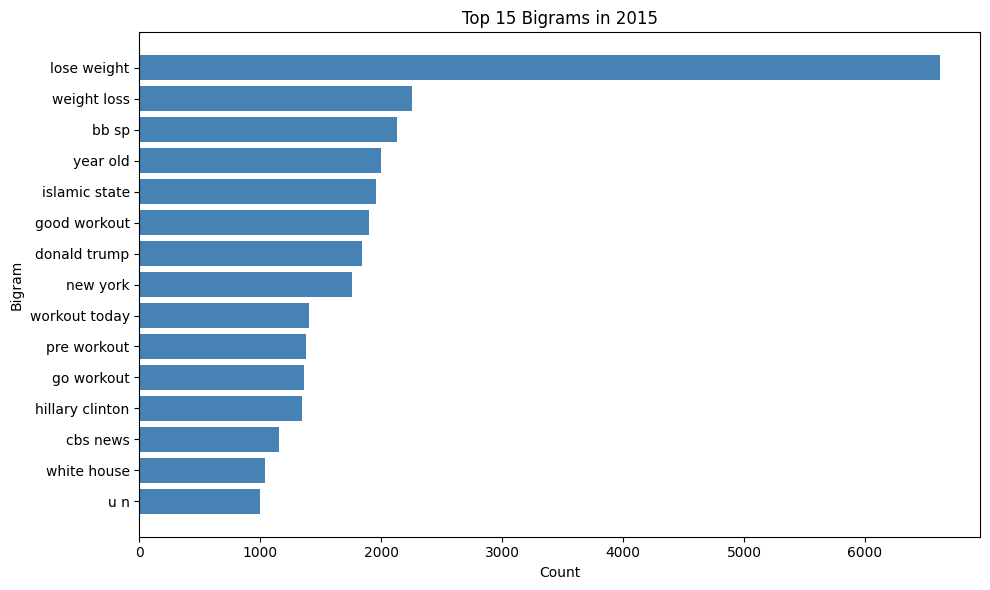

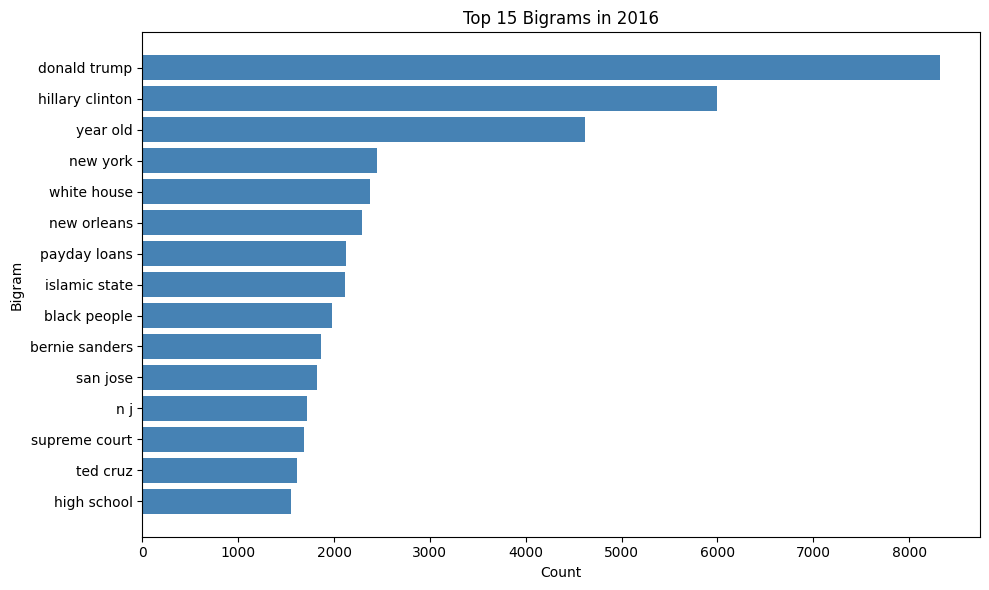

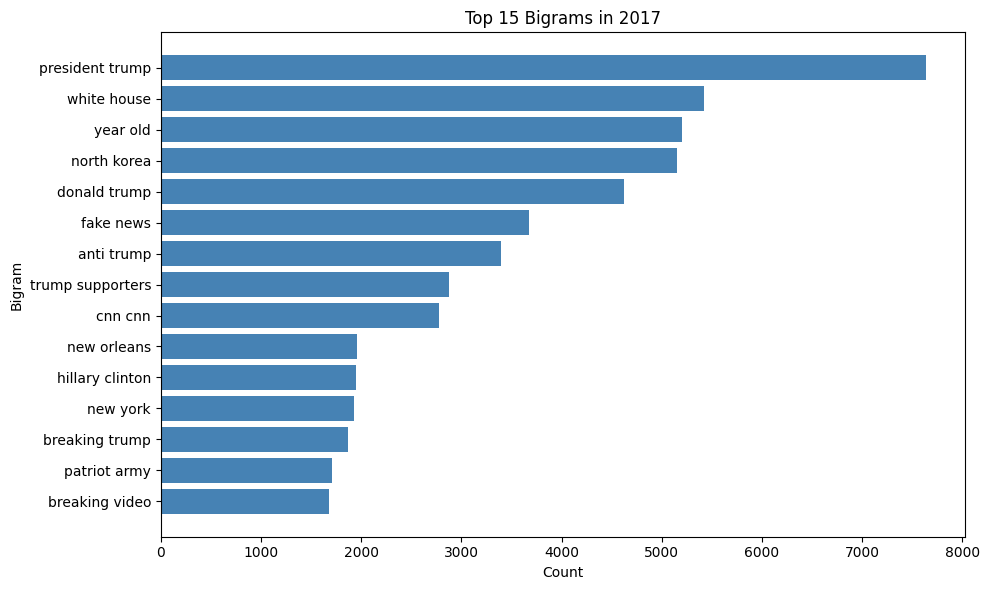

In [16]:
import matplotlib.pyplot as plt

# convert to Pandas
top_bigram_year_pd = top_bigrams_per_year.toPandas()

years = sorted(top_bigram_year_pd["year"].unique())

for yr in years:
    df_yr = (
        top_bigram_year_pd[top_bigram_year_pd["year"] == yr]
        .sort_values("count", ascending=True)
    )
    
    plt.figure(figsize=(10, 6))
    plt.barh(df_yr["bigram"], df_yr["count"], color="steelblue")
    plt.title(f"Top 15 Bigrams in {yr}")
    plt.xlabel("Count")
    plt.ylabel("Bigram")
    plt.tight_layout()
    plt.show()


### Top bigrams by category

Finally, we combine category information with bigram statistics:

- For each `account_category`, compute the **top bigrams**.
- Compare which phrases are characteristic for political trolls vs. news-style accounts, etc.
- Optionally normalise by the number of tweets per category to avoid favouring the largest groups.

This analysis shows **how different account types specialise in different storylines**, for example:
- Certain categories might focus more on domestic politics,
- Others might emphasise foreign policy, race, or other divisive issues.

These results support a narrative in the slides about **segmentation and role-specific messaging** within the IRA ecosystem.


25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:46 WARN RowBasedKeyValueBatch: Calling spill() on

+----------------+--------------------+-----+----+
|account_category|bigram              |count|rank|
+----------------+--------------------+-----+----+
|Commercial      |lose weight         |6592 |1   |
|Commercial      |weight loss         |2209 |2   |
|Commercial      |payday loans        |2112 |3   |
|Commercial      |good workout        |1898 |4   |
|Commercial      |workout today       |1403 |5   |
|Commercial      |pre workout         |1371 |6   |
|Commercial      |go workout          |1352 |7   |
|Commercial      |online payday       |1261 |8   |
|Commercial      |x online            |1203 |9   |
|Commercial      |approved minutes    |1077 |10  |
|Fearmonger      |happy thanksgiving  |580  |1   |
|Fearmonger      |wooow happy         |246  |2   |
|Fearmonger      |ashley madison      |221  |3   |
|Fearmonger      |new york            |213  |4   |
|Fearmonger      |donald trump        |139  |5   |
|Fearmonger      |tiger woods         |114  |6   |
|Fearmonger      |times square 

25/12/09 17:31:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/12/09 17:31:59 WARN RowBasedKeyValueBatch: Calling spill() on

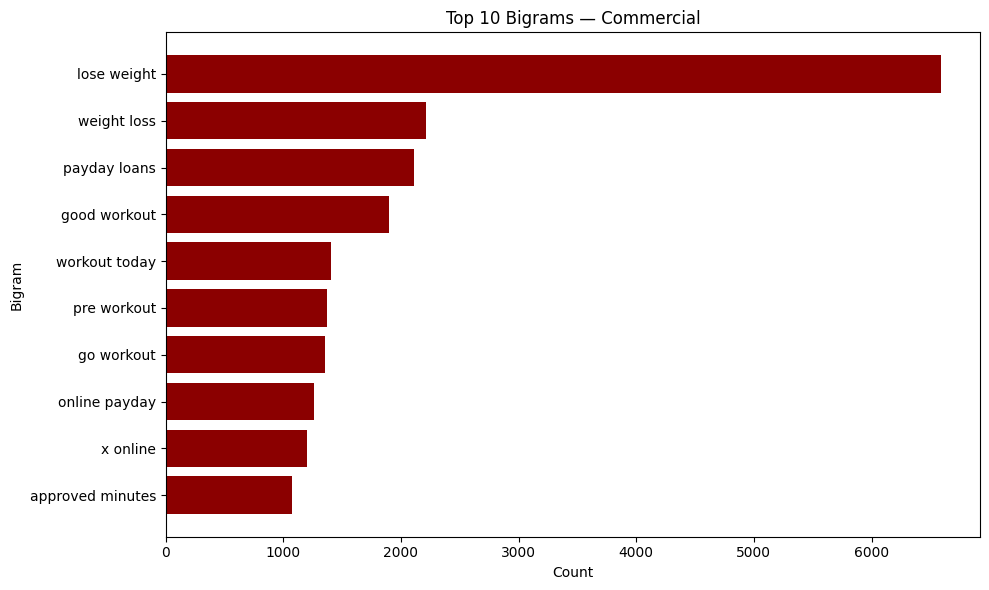

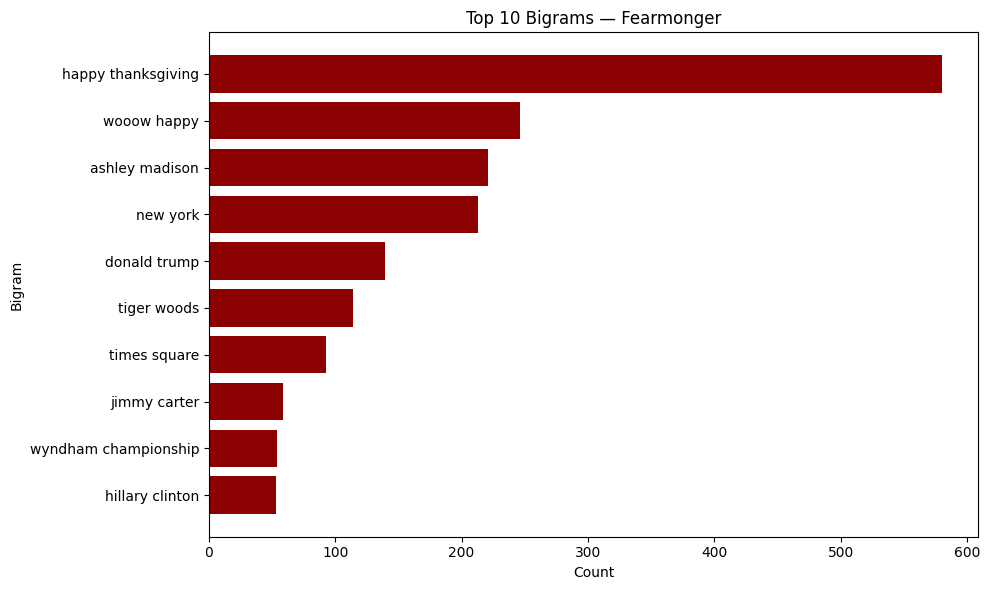

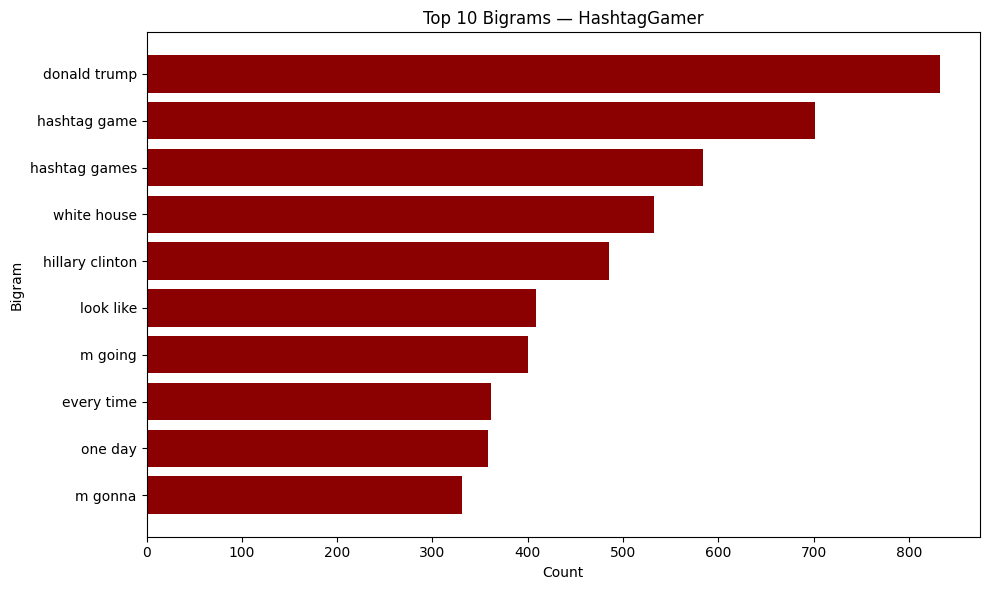

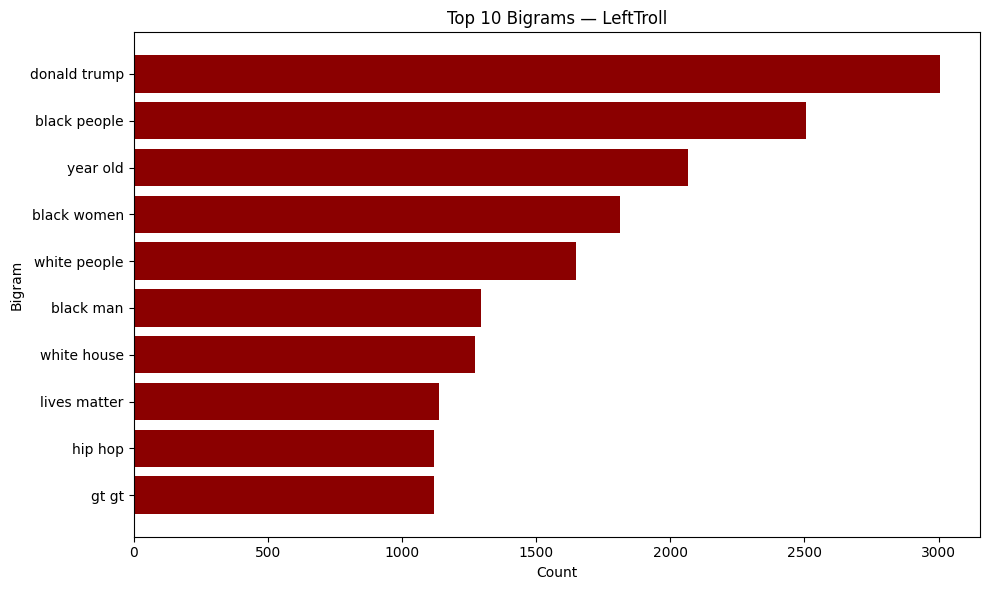

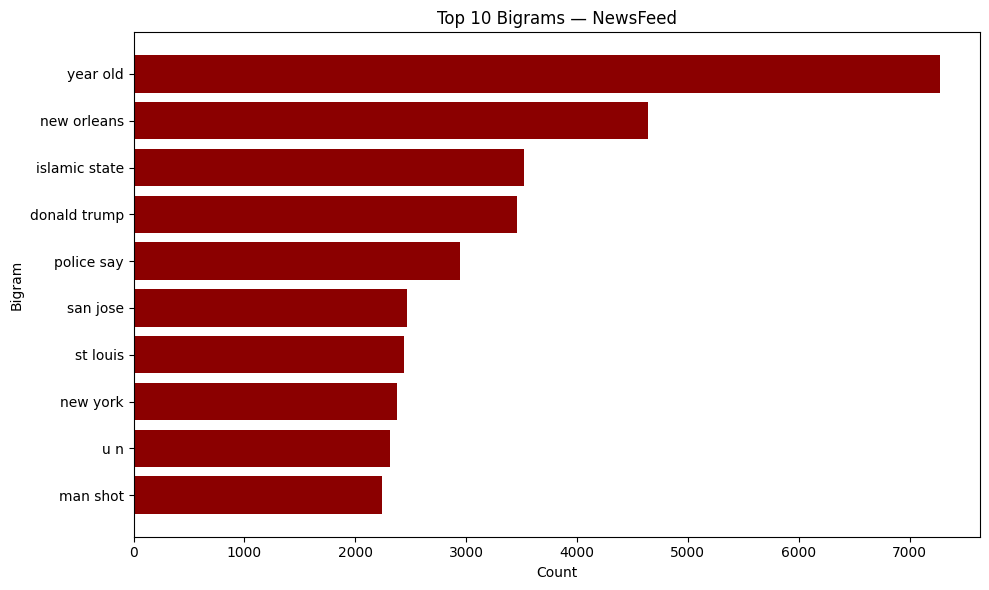

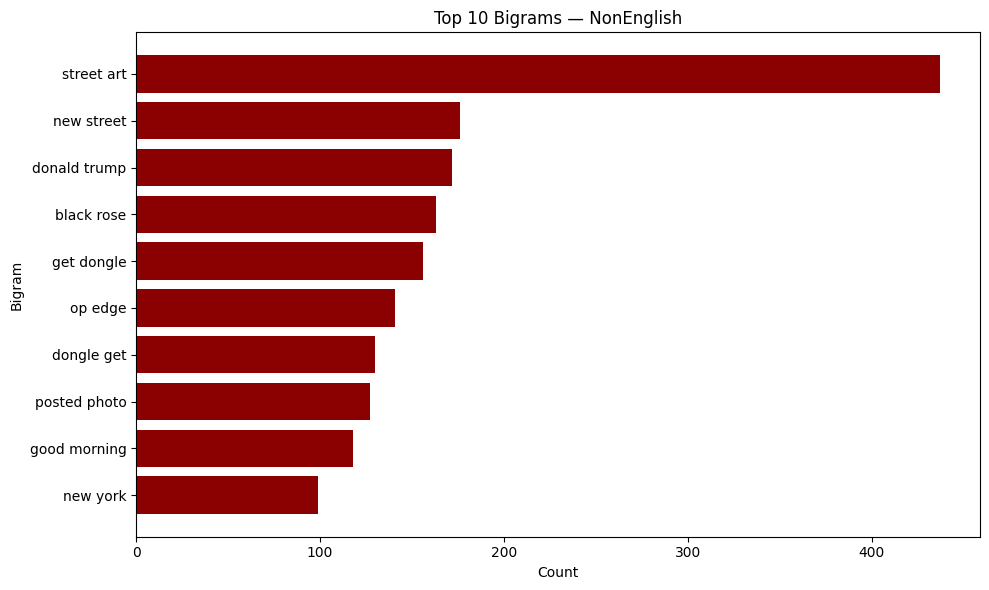

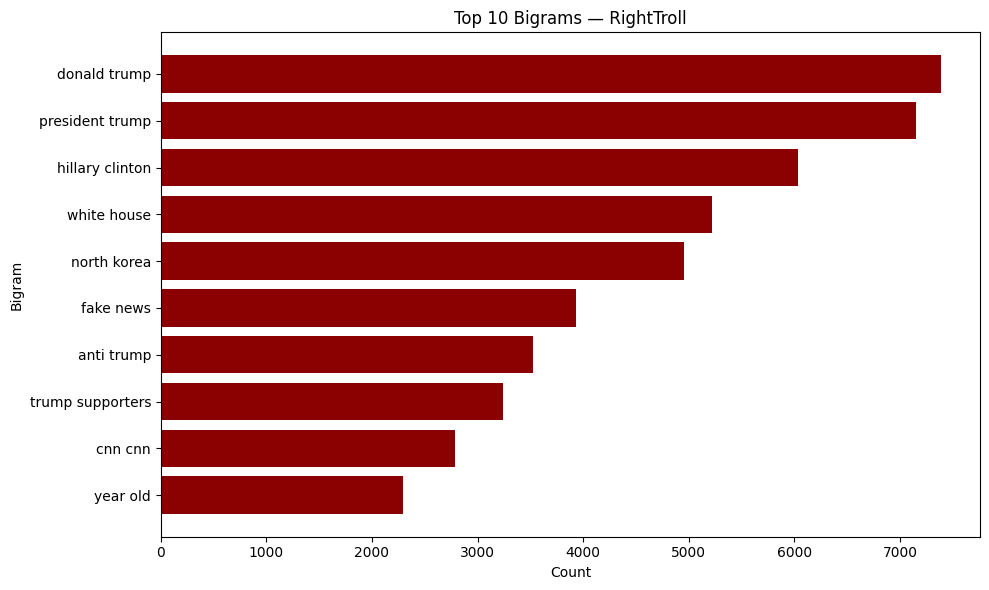

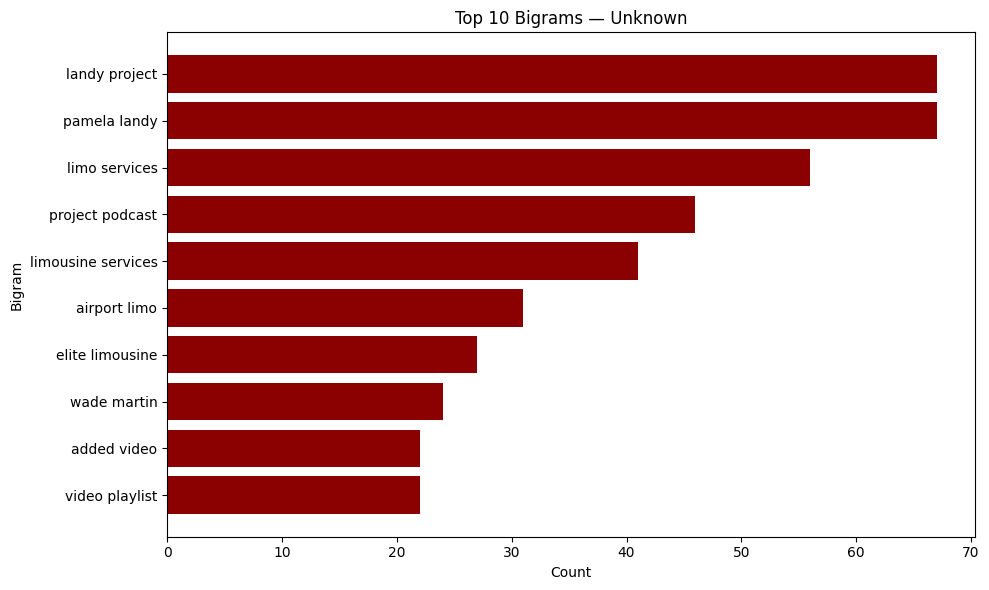

In [17]:
from pyspark.sql.functions import desc

bigrams_by_cat = (
    df_bigrams_exploded
        .groupBy("account_category", "bigram")
        .count()
)

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

w_cat_big = Window.partitionBy("account_category").orderBy(desc("count"))

top_bigrams_by_cat = (
    bigrams_by_cat
        .withColumn("rank", row_number().over(w_cat_big))
        .filter(col("rank") <= 10)
        .orderBy("account_category", "rank")
)

top_bigrams_by_cat.show(100, truncate=False)


bigrams_cat_pd = top_bigrams_by_cat.toPandas()

categories = bigrams_cat_pd["account_category"].unique()

for cat in categories:
    df_cat = (
        bigrams_cat_pd[bigrams_cat_pd["account_category"] == cat]
        .sort_values("count", ascending=True)
    )
    
    plt.figure(figsize=(10, 6))
    plt.barh(df_cat["bigram"], df_cat["count"], color="darkred")
    plt.title(f"Top 10 Bigrams — {cat}")
    plt.xlabel("Count")
    plt.ylabel("Bigram")
    plt.tight_layout()
    plt.show()


## Network Analysis

To conclude our analysis, we investigate the *interaction structure* of IRA accounts through
network analysis. While earlier sections explored what accounts talked about and when they
were active, network analysis helps us understand **how accounts interacted** and **which
accounts played central roles** in the operation.

We construct a **directed mention network**:

- **Nodes** represent IRA-controlled Twitter accounts.
- **Edges** represent one IRA account mentioning another (`@handle`) in a tweet.
- **Edge weight** is the number of mentions.

This lets us examine:

- **Influence hubs**: accounts frequently mentioned by others.  
- **Information broadcasters**: accounts that mention many others.  
- **Structural leadership**: accounts with high PageRank.

PageRank is particularly useful here because it highlights accounts that received attention
from *other important accounts* — a hallmark of coordinated influence operations.

Understanding the structure of this mention network helps us identify which accounts were
central amplifiers of narratives, how different account categories interacted, and which
nodes may have acted as “command-and-control” centers within the broader disinformation
ecosystem.


Raw mention rows: 1035359


25/12/09 17:32:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Number of edges in mention graph: 760383


25/12/09 17:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Graph nodes: 551615 edges: 760383


,handle,pagerank,account_category
1,realdonaldtrump,0.000114,NaN
22,jenn_abrams,0.000039,RightTroll
19,hillaryclinton,0.000036,NaN
54077,tweet_delete,0.000034,NaN
68400,manageflitter,0.000032,NaN
29,midnight,0.000030,NaN
2176,clever_dove,0.000025,NaN
31,youtube,0.000024,NaN
93,politweecs,0.000020,RightTroll
3,potus,0.000019,NaN


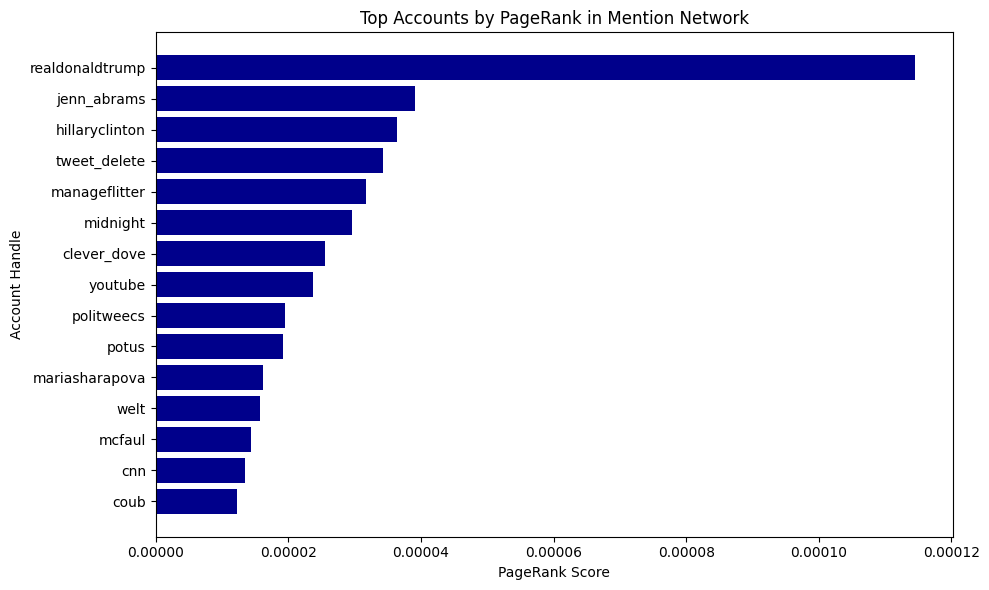

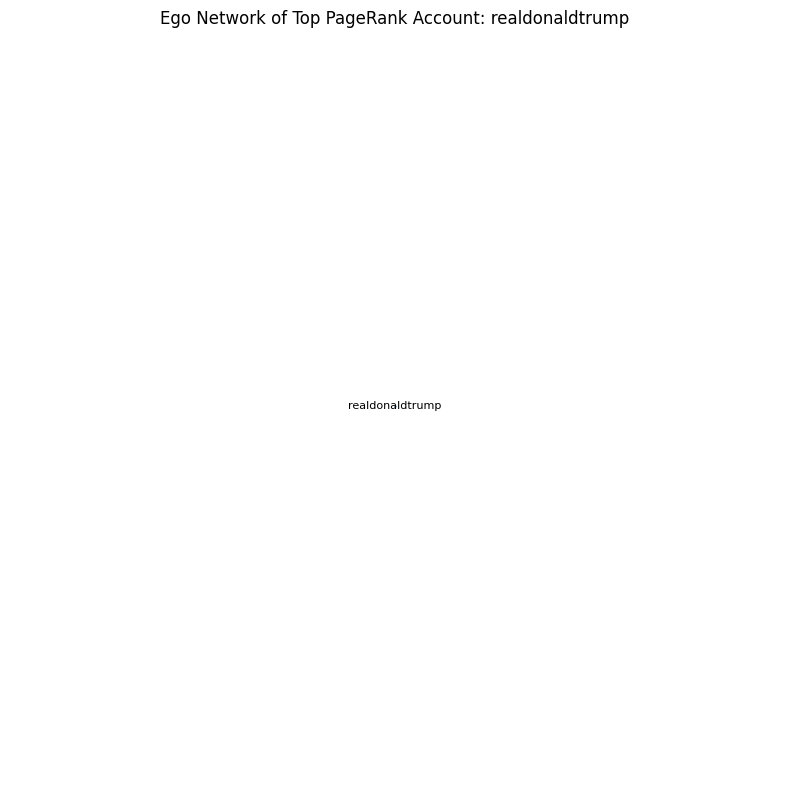

Top IRA hubs: ['jenn_abrams', 'politweecs', 'matevidence', 'danageezus', 'drgregorywest']
Subgraph nodes: 45 edges: 114


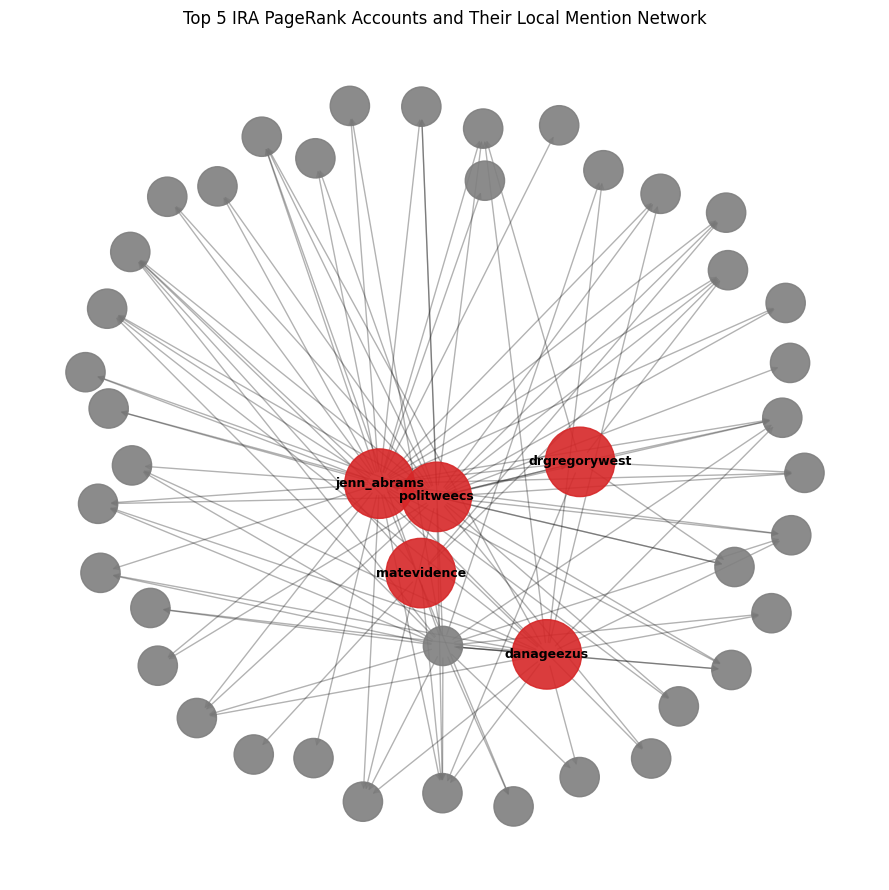

In [18]:
from pyspark.sql.functions import (
    col, lower, regexp_replace, split, explode,
    count, lit, desc
)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# start from 2014 & english
df_net = (
    df_time
        .filter(col("language") == "English")
        .filter(df_time.publish_ts >= "2014-01-01")
        .select("author", "account_category", "content")
)

# normalise author handle
df_net = df_net.withColumn("author_norm", lower(col("author")))

# extract @mentions correctly
df_mentions = (
    df_net
        # keep only @ and word characters for mention detection
        .withColumn("clean_text", regexp_replace(col("content"), r"[^@\w]", " "))
        .withColumn("token", explode(split(col("clean_text"), " ")))
        .filter(col("token").rlike(r"^@\w+"))      # <-- FIXED REGEX
        .withColumn("src", col("author_norm"))
        .withColumn("dst", lower(regexp_replace(col("token"), "@", "")))
        .select("src", "dst")
        .filter(col("src") != col("dst"))
)

print("Raw mention rows:", df_mentions.count())

# weighted edges 
edges_df = (
    df_mentions
        .groupBy("src", "dst")
        .agg(count(lit(1)).alias("weight"))
        .orderBy(desc("weight"))
)

edge_count = edges_df.count()
print("Number of edges in mention graph:", edge_count)

if edge_count == 0:
    print("No edges detected – check mention extraction / filters.")
else:
    edges_pd = edges_df.toPandas()

    # networkx directed graph
    G = nx.DiGraph()
    for _, row in edges_pd.iterrows():
        G.add_edge(row["src"], row["dst"], weight=row["weight"])

    print("Graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

    # running PageRank
    pagerank_scores = nx.pagerank(G, weight="weight")

    pr_df = pd.DataFrame(list(pagerank_scores.items()), columns=["handle", "pagerank"])

    # join back 
    authors_pd = (
        df_net
        .select("author_norm", "account_category")
        .distinct()
        .toPandas()
        .rename(columns={"author_norm": "handle"})
    )

    pr_df = pr_df.merge(authors_pd, on="handle", how="left")

    # sort by PageRank
    pr_df = pr_df.sort_values("pagerank", ascending=False)

    # look at top 20
    display(pr_df.head(20))

    # visualise top page rank accounts
    top_pr = pr_df.head(15)

    plt.figure(figsize=(10, 6))
    plt.barh(top_pr["handle"], top_pr["pagerank"], color="darkblue")
    plt.gca().invert_yaxis()
    plt.xlabel("PageRank Score")
    plt.ylabel("Account Handle")
    plt.title("Top Accounts by PageRank in Mention Network")
    plt.tight_layout()
    plt.show()


# pick the top PageRank account
top_handle = pr_df.iloc[0]["handle"]
top_handle

# build ego network around top node
ego_nodes = nx.ego_graph(G, top_handle, radius=1)  # 1-hop neighbourhood

# build a small DataFrame for ego nodes with category & PR
ego_pr = pr_df[pr_df["handle"].isin(ego_nodes.nodes())].copy()

# map category and pagerank into dicts for quick lookup
cat_map = dict(zip(ego_pr["handle"], ego_pr["account_category"]))
pr_map = dict(zip(ego_pr["handle"], ego_pr["pagerank"]))

# colors by category (simple map)
unique_cats = ego_pr["account_category"].astype(str).unique()
color_map = {cat: i for i, cat in enumerate(unique_cats)}

node_colors = [color_map.get(cat_map.get(n, "Other"), 0) for n in ego_nodes.nodes()]
node_sizes = [3000 * pr_map.get(n, 0.0001) for n in ego_nodes.nodes()]  # scale PR

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(ego_nodes, k=0.5, seed=42)

nx.draw_networkx_nodes(ego_nodes, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.tab10,
                       alpha=0.9)
nx.draw_networkx_edges(ego_nodes, pos, alpha=0.3)
nx.draw_networkx_labels(ego_nodes, pos,
                        font_size=8)

plt.title(f"Ego Network of Top PageRank Account: {top_handle}")
plt.axis("off")
plt.tight_layout()
plt.show()

# ego network viz
# top 5 accounts by PageRank
pr_ira = (
    pr_df[pr_df["account_category"].notna()]
    .sort_values("pagerank", ascending=False)
    .reset_index(drop=True)
)

top_hubs = pr_ira["handle"].head(5).tolist()
print("Top IRA hubs:", top_hubs)

# collect neighbours 
neighbor_candidates = set()

for h in top_hubs:
    preds = set(G.predecessors(h))
    succs = set(G.successors(h))
    neighbor_candidates |= preds | succs

# remove hubs themselves from candidate pool
neighbor_candidates -= set(top_hubs)

# rank neighbours by PageRank and keep only the strongest ones
neighbors_pr = (
    pr_df[pr_df["handle"].isin(neighbor_candidates)]
    .sort_values("pagerank", ascending=False)
    .reset_index(drop=True)
)

TOP_NEIGHBORS = 40   # you can tweak this
top_neighbors = neighbors_pr["handle"].head(TOP_NEIGHBORS).tolist()

nodes_to_keep = set(top_hubs) | set(top_neighbors)
G_sub = G.subgraph(nodes_to_keep).copy()

print("Subgraph nodes:", len(G_sub.nodes()), "edges:", len(G_sub.edges()))

# 3. Build metadata for subgraph nodes
sub_pr = pr_df[pr_df["handle"].isin(G_sub.nodes())].copy()
cat_map = dict(zip(sub_pr["handle"], sub_pr["account_category"]))
pr_map  = dict(zip(sub_pr["handle"], sub_pr["pagerank"]))

# color: red for top hubs, grey for others
node_colors = [
    "tab:red" if n in top_hubs else "tab:gray"
    for n in G_sub.nodes()
]

# size: larger for hubs, smaller for neighbours
node_sizes = [
    2500 if n in top_hubs else 800
    for n in G_sub.nodes()
]

# label only the hubs to keep the plot readable
labels = {n: n for n in top_hubs}

plt.figure(figsize=(9, 9))
pos = nx.spring_layout(G_sub, k=0.8, seed=42)

nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9
)
nx.draw_networkx_edges(G_sub, pos, alpha=0.3, arrowsize=10)
nx.draw_networkx_labels(G_sub, pos, labels=labels, font_size=9, font_weight="bold")

plt.title("Top 5 IRA PageRank Accounts and Their Local Mention Network")
plt.axis("off")
plt.tight_layout()
plt.show()


### Community structure and influential accounts

After constructing the mention network, we go one step further and look at:

- **Communities** detected via a modularity-based algorithm (e.g. Louvain).
- The **size distribution** of communities to see whether a few large clusters dominate.
- The **top accounts by PageRank or in-degree** within the largest communities.

These results help us:

- Identify groups of accounts that interact heavily with each other (potential coordinated clusters).
- Highlight a small set of **key players** that sit at the centre of information flows.

This provides good material for slides summarising “who talks to whom” and which handles are structurally central in the IRA ecosystem.


Top 10 communities by size:


,community,n_nodes
5,5,213801
10,10,103796
11,11,101420
0,0,40328
7,7,39118
2,2,38856
8,8,6031
1,1,4271
6,6,1706
3,3,949



=== Community 5 (size=213801) ===


/var/folders/xs/_4c03gwn52g_g54kjl7w451r0000gn/T/ipykernel_43483/603754048.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"\n=== Community {c} (size={int(comm_sizes[comm_sizes['community'] == c]['n_nodes'])}) ===")


,handle,account_category,pagerank,community
158,racorsino_rose,NaN,0.000003,5
461,bcloritts,NaN,0.000003,5
1602,viewsonearth,NaN,0.000002,5
3937,smartass_girl,NaN,0.000002,5
7059,jaltucher,NaN,0.000002,5
9438,matthew52338399,NaN,0.000002,5
10758,imtheq,NaN,0.000002,5
11610,danifantastic,NaN,0.000002,5
16107,fangirljeanne,NaN,0.000002,5
17324,_pettycrocker,NaN,0.000002,5



=== Community 10 (size=103796) ===


/var/folders/xs/_4c03gwn52g_g54kjl7w451r0000gn/T/ipykernel_43483/603754048.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"\n=== Community {c} (size={int(comm_sizes[comm_sizes['community'] == c]['n_nodes'])}) ===")


,handle,account_category,pagerank,community
1413,jordhall6,NaN,0.000002,10
4031,bapruger77,NaN,0.000002,10
4510,slickerytrigger,NaN,0.000002,10
5473,davidjones720,NaN,0.000002,10
5797,moosegal35,NaN,0.000002,10
14235,jeddamindtricks,NaN,0.000002,10
16922,rodt3,NaN,0.000002,10
18427,booomeringue,NaN,0.000002,10
20178,auntlulie,NaN,0.000002,10
21480,tygressandy,NaN,0.000002,10



=== Community 11 (size=101420) ===


/var/folders/xs/_4c03gwn52g_g54kjl7w451r0000gn/T/ipykernel_43483/603754048.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"\n=== Community {c} (size={int(comm_sizes[comm_sizes['community'] == c]['n_nodes'])}) ===")


,handle,account_category,pagerank,community
2312,justaglasschild,NaN,0.000002,11
3936,shannonlgilstad,NaN,0.000002,11
6414,billycotugno2,NaN,0.000002,11
7484,dnaproteinn,NaN,0.000002,11
8503,dallasbreaking,NaN,0.000002,11
17350,joelladeville,NaN,0.000002,11
20036,airindanyell,NaN,0.000002,11
20060,such_a_frknlady,NaN,0.000002,11
20427,pretsd,NaN,0.000002,11
22078,humbleteej,NaN,0.000002,11


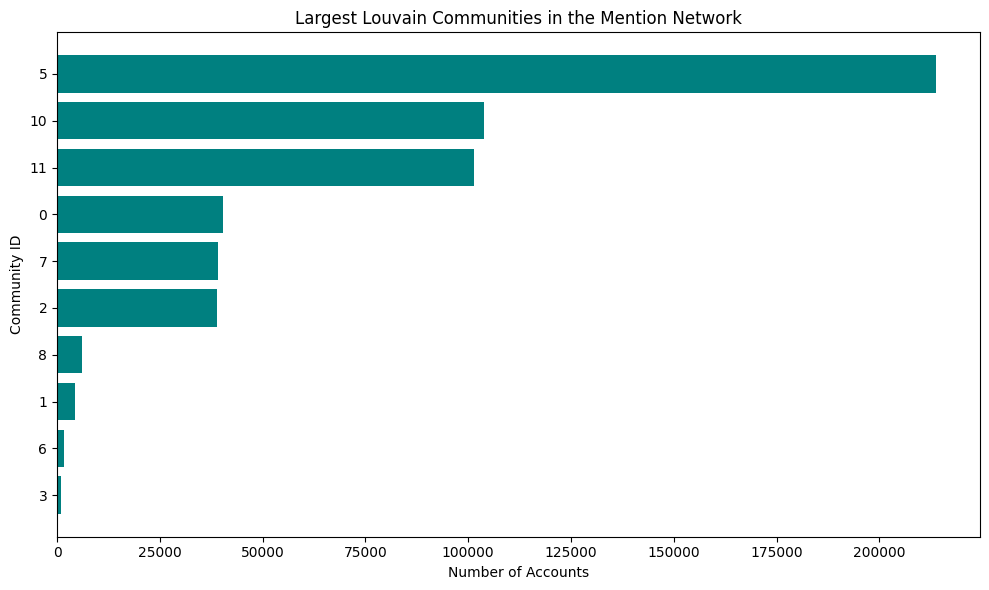

25/12/09 20:42:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1066100 ms exceeds timeout 120000 ms
25/12/09 20:42:32 WARN SparkContext: Killing executors is not supported by current scheduler.
25/12/09 20:49:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [ ]:
# pip install python-louvain
import community.community_louvain as community_louvain

G_undirected = G.to_undirected()

partition = community_louvain.best_partition(G_undirected, weight="weight")


# build df of communities
comm_df = pd.DataFrame(
    {"handle": list(partition.keys()),
     "community": list(partition.values())}
)

# merge with PageRank + category info
pr_comm_df = (
    pr_df.merge(comm_df, on="handle", how="inner")
         .copy()
)

# community sizes 
comm_sizes = (
    pr_comm_df.groupby("community")["handle"]
              .nunique()
              .reset_index(name="n_nodes")
              .sort_values("n_nodes", ascending=False)
)

print("Top 10 communities by size:")
display(comm_sizes.head(10))

# look at PageRank within biggest communities
top_communities = comm_sizes.head(3)["community"].tolist()  # adjust number if you want more

for c in top_communities:
    print(f"\n=== Community {c} (size={int(comm_sizes[comm_sizes['community'] == c]['n_nodes'])}) ===")
    sub = (
        pr_comm_df[pr_comm_df["community"] == c]
        .sort_values("pagerank", ascending=False)
        .head(10)
    )
    display(sub[["handle", "account_category", "pagerank", "community"]])

# simple bar chart / cmmunity sizes 
top_comm_plot = comm_sizes.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_comm_plot["community"].astype(str), top_comm_plot["n_nodes"], color="teal")
plt.gca().invert_yaxis()
plt.xlabel("Number of Accounts")
plt.ylabel("Community ID")
plt.title("Largest Louvain Communities in the Mention Network")
plt.tight_layout()
plt.show()
